In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from rapidfuzz import process, fuzz

# Initial exploration of the data

Open analysis set

In [2]:
analysis_set_file = Path("../data/source/analysis_set_0930.json")

with open(analysis_set_file, "r", encoding="utf-8") as f:
    analysis_set = json.load(f)

len(analysis_set)

27634

Inspect first element of the list of dicts

In [3]:
analysis_set[1]

{'release_group_mbid': '9e5a8111-562b-30c1-9ef2-04106388f80f',
 'title': 'Balance & Options',
 'type': 'Album',
 'first_release_date': '2000-05-16',
 'artist_credit': {'full_credit_name': 'DJ Quik',
  'artists': [{'name': 'DJ Quik',
    'artist_mbid': '542f4f08-4d8f-48db-a414-d3a33a62929f',
    'country': 'US',
    'type': 'Person',
    'disambiguation': 'West Coast US rapper & producer'}]},
 'external_links': {'discogs': 'https://www.discogs.com/master/188345',
  'allmusic': None,
  'wikidata': 'https://www.wikidata.org/wiki/Q4849944'},
 'genre_info': {'genres_discogs': ['Hip Hop'],
  'styles_discogs': ['Gangsta'],
  'genres_mb': ['contemporary r&b',
   'gangsta rap',
   'hardcore hip hop',
   'hip hop',
   'west coast hip hop'],
  'tags_mb': ['contemporary r&b',
   'gangsta rap',
   'hardcore hip hop',
   'hip hop',
   'west coast hip hop']},
 'releases': [{'release_mbid': '7cfeebb6-9d0f-4c27-9af1-e2af81fb1f58',
   'barcode': '078221641920',
   'disambiguation': '',
   'date': '2000-

In [4]:
# for release in analysis_set:
#     if release["cover_art"]["visual_features"]["face_detection"]["n_faces"] == 0:
#         print(release["cover_art"]["visual_features"]["face_detection"])

Inspect how artist credit is is saved, how many artists and countries normally per artist_credit

In [5]:
n_multiple_artists = 0
n_artists_list = []
diff_countries_list = []

for mbid in analysis_set:
    artist_credit = mbid["artist_credit"]
    artists = artist_credit["artists"]
    n_artists = len(artist_credit["artists"])
    if n_artists > 1:
        n_multiple_artists += 1
        n_artists_list.append(n_artists)
        
        # Collect all unique countries (ignoring missing ones)
        countries = {a["country"] for a in artists if a.get("country")}
        
        # If more than one unique country → they differ
        diff_countries = len(countries) > 1
        diff_countries_list.append(diff_countries)

import statistics

if n_artists_list:  # avoid error if list is empty
    mean_artists = statistics.mean(n_artists_list)
else:
    mean_artists = 0

n_diff_countries = sum(diff_countries_list)

print(f"Number of multi-artist entries: {n_multiple_artists}")
print(f"Mean number of artists per multi-artist entry: {mean_artists:.2f}")
print(f"Number of multi-artist entries with different countries: {n_diff_countries}")


Number of multi-artist entries: 1337
Mean number of artists per multi-artist entry: 2.38
Number of multi-artist entries with different countries: 402


Inspect how many unique genres and formats there are

In [6]:
genres_values = []
formats_values = []
for mbid in analysis_set:
    genres = mbid["genre_info"]["genres_discogs"]
    genres_values += genres
    for release in mbid["releases"]:
        formats_values += release["format"]

unique_genres = set(genres_values)
unique_formats = set(formats_values)

print("Unique genres:", len(unique_genres), unique_genres)
print("Unique formats:", len(unique_formats), unique_formats)


Unique genres: 13 {'Funk / Soul', 'Electronic', 'Reggae', 'Jazz', 'Classical', 'Stage & Screen', 'Brass & Military', 'Blues', 'Folk, World, & Country', 'Latin', 'Rock', 'Pop', 'Hip Hop'}
Unique formats: 70 {'CD', 'HDCD', '8-Track Cartridge', 'VCD', '8cm CD', 'Reel-to-reel', 'SHM-CD', 'Zip Disk', 'DataPlay', 'VinylDisc', 'DualDisc (DVD-Video side)', 'DualDisc', 'Enhanced CD', 'SACD (2 channels)', 'SACD', 'SHM-SACD (2 channels)', 'Hybrid SACD (SACD layer)', 'Hybrid SACD (SACD layer, multichannel)', 'CED', 'Vinyl', 'Download Card', 'DualDisc (DVD-Audio side)', 'UMD', 'Digital Media', 'DVD-Audio', 'HQCD', 'DualDisc (CD side)', 'CDV', 'Flexi-disc', 'PlayTape', 'DVDplus (DVD-Video side)', 'USB Flash Drive', 'DCC', 'Phonograph record', 'Hybrid SACD (CD layer)', '12" Vinyl', '7" Flexi-disc', 'VHS', 'DVD', 'Hybrid SACD (SACD layer, 2 channels)', 'Data CD', 'DVD-R Video', 'SACD (multichannel)', '10" Vinyl', 'Cassette', 'DVDplus (DVD-Audio side)', 'Mixed Mode CD', 'MiniDisc', 'CD+G', 'HD-DVD', 'D

# Define desired structure of df for analysis

In [7]:
desired_columns = [

    # data about the album itself
    'release_group_mbid',
    'title',
    'year',
    'artist_credit_full_credit_name',
    'artist_credit_main_artist_country',
    'artist_credit_main_artist_type',
    'genre_Blues',
    'genre_Classical',
    'genre_Electronic',
    'genre_Folk, World, & Country',
    'genre_Funk / Soul',
    'genre_Hip Hop',
    'genre_Jazz',
    'genre_Latin',
    'genre_Pop',
    'genre_Reggae',
    'genre_Rock',
    # 'genres_discogs', # multi hot?
    'format_MiniDisc',
    'format_Compact Disc',
    'format_Vinyl',
    'format_Digital Media',
    'format_Cassette',
    # 'release_formats', # multi hot?

    # visual features

    # visual features colors
    'dominant_colors_color_1_L',
    'dominant_colors_color_1_a',
    'dominant_colors_color_1_b',
    'dominant_colors_color_1_chroma',
    'dominant_colors_color_2_L',
    'dominant_colors_color_2_a',
    'dominant_colors_color_2_b',
    'dominant_colors_color_2_chroma',
    'dominant_colors_color_3_L',
    'dominant_colors_color_3_a',
    'dominant_colors_color_3_b',
    'dominant_colors_color_3_chroma',
    'dominant_colors_color_4_L',
    'dominant_colors_color_4_a',
    'dominant_colors_color_4_b',
    'dominant_colors_color_4_chroma',
    'dominant_colors_color_5_L',
    'dominant_colors_color_5_a',
    'dominant_colors_color_5_b',
    'dominant_colors_color_5_chroma',
    'dominant_colors_L_mean',
    'dominant_colors_L_std',
    'dominant_colors_a_mean',
    'dominant_colors_a_std',
    'dominant_colors_b_mean',
    'dominant_colors_b_std',
    'dominant_colors_chroma_mean',
    'dominant_colors_chroma_std',
    'prominent_colors_color_1_L',
    'prominent_colors_color_1_a',
    'prominent_colors_color_1_b',
    'prominent_colors_color_1_chroma',
    'prominent_colors_color_2_L',
    'prominent_colors_color_2_a',
    'prominent_colors_color_2_b',
    'prominent_colors_color_2_chroma',
    'prominent_colors_color_3_L',
    'prominent_colors_color_3_a',
    'prominent_colors_color_3_b',
    'prominent_colors_color_3_chroma',
    'prominent_colors_color_4_L',
    'prominent_colors_color_4_a',
    'prominent_colors_color_4_b',
    'prominent_colors_color_4_chroma',
    'prominent_colors_color_5_L',
    'prominent_colors_color_5_a',
    'prominent_colors_color_5_b',
    'prominent_colors_color_5_chroma',
    'prominent_colors_L_mean',
    'prominent_colors_L_std',
    'prominent_colors_a_mean',
    'prominent_colors_a_std',
    'prominent_colors_b_mean',
    'prominent_colors_b_std',
    'prominent_colors_chroma_mean',
    'prominent_colors_chroma_std',


    # visual features visual complexity
    'vf_edge_density',
    'vf_orientation_entropy',
    'vf_pixel_intensity_entropy',
    'vf_glcm_contrast',
    'vf_glcm_homogeneity',
    'vf_glcm_energy',
    'vf_glcm_correlation',
    'vf_glcm_entropy',
    'vf_lbp_entropy',
    'vf_lbp_energy',
    'vf_visual_complexity',

    # visual features faces
    'vf_face_summary_n_faces',
    'vf_face_summary_average_relative_size',
    'vf_largest_face_relative_size',

    # visual features text
    'vf_text_summary_n_texts',
    'vf_text_summary_average_relative_size',
    'vf_largest_text_relative_size'
]

# Cleaning and preprocessing

In [8]:
df = pd.json_normalize(
    analysis_set,
    max_level=1
)

In [9]:
df.head()

,release_group_mbid,title,type,first_release_date,releases,artist_credit.full_credit_name,artist_credit.artists,external_links.discogs,external_links.allmusic,external_links.wikidata,...,genre_info.genres_mb,genre_info.tags_mb,cover_art.id,cover_art.types,cover_art.image,cover_art.thumbnails,cover_art.approved,cover_art.release,cover_art.visual_features,cover_art
0,85afc0a2-2b3d-31cb-abd1-0c4eadae48a4,Plain Rap,Album,2000-10-30,[{'release_mbid': '006fc512-5c2d-46a5-a11b-787...,The Pharcyde,"[{'name': 'The Pharcyde', 'artist_mbid': 'd713...",https://www.discogs.com/master/56161,https://www.allmusic.com/album/mw0000102967,https://www.wikidata.org/wiki/Q7200623,...,[hip hop],[hip hop],4786131688,[Front],http://coverartarchive.org/release/90bccbde-88...,"{'px_1200': None, 'px_250': None, 'px_500': No...",True,http://musicbrainz.org/release/90bccbde-88a6-4...,{'colors': {'dominant_colors': [{'hex': '#FDFE...,NaN
1,9e5a8111-562b-30c1-9ef2-04106388f80f,Balance & Options,Album,2000-05-16,[{'release_mbid': '7cfeebb6-9d0f-4c27-9af1-e2a...,DJ Quik,"[{'name': 'DJ Quik', 'artist_mbid': '542f4f08-...",https://www.discogs.com/master/188345,None,https://www.wikidata.org/wiki/Q4849944,...,"[contemporary r&b, gangsta rap, hardcore hip h...","[contemporary r&b, gangsta rap, hardcore hip h...",40577720329,[Front],https://coverartarchive.org/release/2fecbafc-d...,{'px_1200': 'https://coverartarchive.org/relea...,True,https://musicbrainz.org/release/2fecbafc-d64b-...,{'colors': {'dominant_colors': [{'hex': '#0E0D...,NaN
2,e7702da7-6ecd-3a6b-90be-dc4e10b0c22e,"Trilogy: Conflict, Climax, Resolution",Album,2000-10-24,[{'release_mbid': 'df17aae8-1815-4e40-a80b-600...,Souls of Mischief,"[{'name': 'Souls of Mischief', 'artist_mbid': ...",https://www.discogs.com/master/66277,https://www.allmusic.com/album/mw0000101896,https://www.wikidata.org/wiki/Q7842074,...,"[alternative hip hop, hip hop]","[alternative hip hop, hip hop]",4774319874,[Front],http://coverartarchive.org/release/df17aae8-18...,"{'px_1200': None, 'px_250': None, 'px_500': No...",True,http://musicbrainz.org/release/df17aae8-1815-4...,{'colors': {'dominant_colors': [{'hex': '#5734...,NaN
3,9352d5bd-202b-3730-94d9-2113043506de,Unleashed,Album,2000-10-17,[{'release_mbid': '69b8f706-38f1-4de0-ac30-d54...,Unsung Heroes,"[{'name': 'Unsung Heroes', 'artist_mbid': '9d0...",https://www.discogs.com/master/106977,None,None,...,[hip hop],[hip hop],3000092013,[Front],http://coverartarchive.org/release/69b8f706-38...,"{'px_1200': None, 'px_250': None, 'px_500': No...",True,http://musicbrainz.org/release/69b8f706-38f1-4...,{'colors': {'dominant_colors': [{'hex': '#3C35...,NaN
4,b701014e-9697-397a-b257-00be44862a59,D.I.T.C.,Album,2000-02-21,[{'release_mbid': 'c5ac991d-3a0a-4796-9faf-180...,D.I.T.C.,"[{'name': 'D.I.T.C.', 'artist_mbid': 'a607bac0...",https://www.discogs.com/master/20039,None,https://www.wikidata.org/wiki/Q3010474,...,[hip hop],"[hip hop, hip-hop]",4410291260,[Front],http://coverartarchive.org/release/c5ac991d-3a...,{'px_1200': 'http://coverartarchive.org/releas...,True,https://musicbrainz.org/release/c5ac991d-3a0a-...,{'colors': {'dominant_colors': [{'hex': '#9774...,NaN


In [10]:
df.columns

Index(['release_group_mbid', 'title', 'type', 'first_release_date', 'releases',
       'artist_credit.full_credit_name', 'artist_credit.artists',
       'external_links.discogs', 'external_links.allmusic',
       'external_links.wikidata', 'genre_info.genres_discogs',
       'genre_info.styles_discogs', 'genre_info.genres_mb',
       'genre_info.tags_mb', 'cover_art.id', 'cover_art.types',
       'cover_art.image', 'cover_art.thumbnails', 'cover_art.approved',
       'cover_art.release', 'cover_art.visual_features', 'cover_art'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27634 entries, 0 to 27633
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   release_group_mbid              27634 non-null  object 
 1   title                           27634 non-null  object 
 2   type                            27631 non-null  object 
 3   first_release_date              27634 non-null  object 
 4   releases                        27634 non-null  object 
 5   artist_credit.full_credit_name  27634 non-null  object 
 6   artist_credit.artists           27634 non-null  object 
 7   external_links.discogs          27634 non-null  object 
 8   external_links.allmusic         11716 non-null  object 
 9   external_links.wikidata         17770 non-null  object 
 10  genre_info.genres_discogs       27634 non-null  object 
 11  genre_info.styles_discogs       27634 non-null  object 
 12  genre_info.genres_mb            

## 1. Drop undesired columns
- External links
- Musicbrainz genres and tags, and discogs styles
- Metadata about cover art (from musicbrainz, the id, type, links, approved, etc)
- "type" is always "Album"

In [12]:
df = df.drop(df.filter(like="external_links").columns, axis=1)
df = df.drop(["genre_info.genres_mb", "genre_info.tags_mb", "genre_info.styles_discogs"], axis=1)
cover_art_metadata_columns = ['cover_art.id', 'cover_art.types', 'cover_art.image', 'cover_art.thumbnails', 'cover_art.approved', 'cover_art.release']
df = df.drop(cover_art_metadata_columns, axis=1)
df = df.drop("cover_art", axis=1)
df = df.drop("type", axis=1)

## 2. Transform columns that are collections (dicts or lists)
- Convert "releases" column (a dict) to a list of formats containing all the formats the release group has been released in any release
- Convert "artist_credit.artists" (a list) into two columns: the country of the first (main) artist and he type of the first (main) artist. Also rename full_credit_name
- Rename column "genre_info.genres_discogs" to "genres_discogs"
- Extract per-color features (L, a, b, chroma (saturation)) for the 5 dominant and 5 prominent colors of each cover, plus palette-level summaries (mean and std for each channel), providing both detailed and aggregated views of color information.
- Convert "cover_art.visual_features" (a dict) into the columns we want to keep that contain the comparable and aggregable information across the dataset, using a function, except for color features.
- Standardize date column "first_release_date" to follow "YYYY-MM-DD" and take only the year
- Reorder when necessary to keep desired order of columns

In [13]:
df["release_formats"] = df["releases"].apply(
    lambda releases: list({fmt for r in (releases or []) for fmt in r.get("format", [])})
)

df = df.drop("releases", axis=1)

# Keep only rows where release_formats is not empty
df = df[df["release_formats"].apply(len) > 0]

In [14]:
df["artist_credit_main_artist_country"] = df["artist_credit.artists"].apply(
    lambda x: x[0].get("country") if isinstance(x, list) and x else None
)
df["artist_credit_main_artist_type"] = df["artist_credit.artists"].apply(
    lambda x: x[0].get("type") if isinstance(x, list) and x else None
)
df = df.drop("artist_credit.artists", axis=1)
df = df.rename(columns={"artist_credit.full_credit_name": "artist_credit_full_credit_name"})

Computed summary stats per palette (dominant, prominent). → interpretable, low-dimension, good for correlations.

I Keep the color features per each color and maybe in the future I only keep the first 2 dominant + first 2 prominent colors. → preserves nuance for clustering experiments.

In [15]:
# import pandas as pd
# import numpy as np

# def extract_color_features(vf: dict) -> dict:
#     """
#     Extract per-color features (L, a, b, chroma) for dominant and prominent palettes,
#     plus aggregated mean and std summaries per palette.
#     """
#     out = {}

#     if not isinstance(vf, dict):
#         return out

#     colors = vf.get("colors", {})
    
#     for palette_name in ["dominant_colors", "prominent_colors"]:
#         palette = colors.get(palette_name, [])
        
#         # Per-color features (up to 5)
#         for i, c in enumerate(palette[:5], start=1):
#             lab = c.get("lab", [None, None, None])
#             L, a, b = lab if len(lab) == 3 else (None, None, None)
#             chroma = np.sqrt(a**2 + b**2) if a is not None and b is not None else None
            
#             out[f"{palette_name}_color_{i}_L"] = L
#             out[f"{palette_name}_color_{i}_a"] = a
#             out[f"{palette_name}_color_{i}_b"] = b
#             out[f"{palette_name}_color_{i}_chroma"] = chroma
        
#         # Aggregated statistics (mean and std)
#         Ls, As, Bs, Cs = [], [], [], []
#         for c in palette[:5]:
#             lab = c.get("lab", [None, None, None])
#             if lab and len(lab) == 3:
#                 L, a, b = lab
#                 chroma = np.sqrt(a**2 + b**2)
#                 Ls.append(L)
#                 As.append(a)
#                 Bs.append(b)
#                 Cs.append(chroma)
        
#         if Ls:  # only compute if non-empty
#             out[f"{palette_name}_L_mean"] = np.mean(Ls)
#             out[f"{palette_name}_L_std"] = np.std(Ls)
#             out[f"{palette_name}_a_mean"] = np.mean(As)
#             out[f"{palette_name}_a_std"] = np.std(As)
#             out[f"{palette_name}_b_mean"] = np.mean(Bs)
#             out[f"{palette_name}_b_std"] = np.std(Bs)
#             out[f"{palette_name}_chroma_mean"] = np.mean(Cs)
#             out[f"{palette_name}_chroma_std"] = np.std(Cs)
#         else:
#             for stat in ["L_mean", "L_std", "a_mean", "a_std", "b_mean", "b_std", "chroma_mean", "chroma_std"]:
#                 out[f"{palette_name}_{stat}"] = None
    
#     return out

# # Apply to your dataframe
# color_features_expanded = df["cover_art.visual_features"].apply(extract_color_features).apply(pd.Series)

# # Merge with df
# df = pd.concat([df, color_features_expanded], axis=1)

In [16]:
import pandas as pd
import numpy as np

def weighted_mean(values, weights):
    values, weights = np.array(values), np.array(weights)
    return np.sum(values * weights) / np.sum(weights)

def weighted_std(values, weights):
    values, weights = np.array(values), np.array(weights)
    mean = weighted_mean(values, weights)
    variance = np.sum(weights * (values - mean) ** 2) / np.sum(weights)
    return np.sqrt(variance)

def extract_color_features(vf: dict) -> dict:
    """
    Extract per-color features (L, a, b, chroma) for dominant and prominent palettes,
    plus aggregated weighted mean and std summaries per palette.
    """
    out = {}

    if not isinstance(vf, dict):
        return out

    colors = vf.get("colors", {})
    
    for palette_name in ["dominant_colors", "prominent_colors"]:
        palette = colors.get(palette_name, [])
        
        # Per-color features (up to 5)
        for i, c in enumerate(palette[:5], start=1):
            lab = c.get("lab", [None, None, None])
            L, a, b = lab if len(lab) == 3 else (None, None, None)
            chroma = np.sqrt(a**2 + b**2) if a is not None and b is not None else None
            
            out[f"{palette_name}_color_{i}_L"] = L
            out[f"{palette_name}_color_{i}_a"] = a
            out[f"{palette_name}_color_{i}_b"] = b
            out[f"{palette_name}_color_{i}_chroma"] = chroma
        
        # Collect values + weights for weighted statistics
        Ls, As, Bs, Cs, Ws = [], [], [], [], []
        for c in palette[:5]:
            lab = c.get("lab", [None, None, None])
            w = c.get("weight", None)
            if lab and len(lab) == 3 and w is not None:
                L, a, b = lab
                chroma = np.sqrt(a**2 + b**2)
                Ls.append(L)
                As.append(a)
                Bs.append(b)
                Cs.append(chroma)
                Ws.append(w)
        
        if Ls:
            out[f"{palette_name}_L_mean"] = weighted_mean(Ls, Ws)
            out[f"{palette_name}_L_std"] = weighted_std(Ls, Ws)
            out[f"{palette_name}_a_mean"] = weighted_mean(As, Ws)
            out[f"{palette_name}_a_std"] = weighted_std(As, Ws)
            out[f"{palette_name}_b_mean"] = weighted_mean(Bs, Ws)
            out[f"{palette_name}_b_std"] = weighted_std(Bs, Ws)
            out[f"{palette_name}_chroma_mean"] = weighted_mean(Cs, Ws)
            out[f"{palette_name}_chroma_std"] = weighted_std(Cs, Ws)
        else:
            for stat in ["L_mean", "L_std", "a_mean", "a_std", "b_mean", "b_std", "chroma_mean", "chroma_std"]:
                out[f"{palette_name}_{stat}"] = None
    
    return out

# Apply to your dataframe
color_features_expanded = df["cover_art.visual_features"].apply(extract_color_features).apply(pd.Series)

# Merge back
df = pd.concat([df, color_features_expanded], axis=1)


In [17]:
def extract_visual_features(vf: dict) -> dict:
    out = {col: None for col in [
        "vf_edge_density",
        "vf_orientation_entropy",
        "vf_pixel_intensity_entropy",
        "vf_glcm_contrast",
        "vf_glcm_homogeneity",
        "vf_glcm_energy",
        "vf_glcm_correlation",
        "vf_glcm_entropy",
        "vf_lbp_entropy",
        "vf_lbp_energy",
        "vf_visual_complexity",
        "vf_face_summary_n_faces",
        "vf_face_summary_average_relative_size",
        "vf_largest_face_relative_size",
        "vf_text_summary_n_texts",
        "vf_text_summary_average_relative_size",
        "vf_largest_text_relative_size"
    ]}
    
    if not isinstance(vf, dict):
        return out
    
    # Visual complexity
    vc = vf.get("visual_complexity_descriptors", {})
    td = vc.get("texture_descriptors", {})
    out["vf_edge_density"] = td.get("edge_density")
    out["vf_orientation_entropy"] = td.get("orientation_entropy")
    out["vf_pixel_intensity_entropy"] = td.get("pixel_intensity_entropy")
    out["vf_glcm_contrast"] = td.get("glcm_contrast")
    out["vf_glcm_homogeneity"] = td.get("glcm_homogeneity")
    out["vf_glcm_energy"] = td.get("glcm_energy")
    out["vf_glcm_correlation"] = td.get("glcm_correlation")
    out["vf_glcm_entropy"] = td.get("glcm_entropy")
    out["vf_lbp_entropy"] = td.get("lbp_entropy")
    out["vf_lbp_energy"] = td.get("lbp_energy")
    out["vf_visual_complexity"] = vc.get("visual_complexity")
    
    # Face detection
    fd = vf.get("face_detection", {})
    out["vf_face_summary_n_faces"] = fd.get("n_faces")
    out["vf_face_summary_average_relative_size"] = fd.get("average_relative_size")
    if isinstance(fd.get("largest_face"), dict):
        if out["vf_face_summary_n_faces"] == 0:
            out["vf_largest_face_relative_size"] = 0
        else:
            out["vf_largest_face_relative_size"] = fd["largest_face"].get("relative_size", 0)
    
    # Text detection
    td2 = vf.get("text_detection", {})
    out["vf_text_summary_n_texts"] = td2.get("n_texts")
    out["vf_text_summary_average_relative_size"] = td2.get("average_relative_size")
    if isinstance(td2.get("largest_text"), dict):
        if out["vf_text_summary_n_texts"] == 0:
            out["vf_largest_text_relative_size"] = 0
        else:
            out["vf_largest_text_relative_size"] = td2["largest_text"].get("relative_size", 0)
    
    return out

visual_features_expanded = df["cover_art.visual_features"].apply(extract_visual_features).apply(pd.Series)
df = pd.concat([df, visual_features_expanded], axis=1)
df.loc[df["vf_text_summary_n_texts"] == 0, "vf_largest_text_relative_size"] = 0
df.loc[df["vf_face_summary_n_faces"] == 0, "vf_largest_face_relative_size"] = 0


In [18]:
df = df.drop("cover_art.visual_features", axis=1)

In [19]:
def fix_date_string(x):
    if pd.isna(x):
        return x
    s = str(x)
    if len(s) == 4:          # just year, e.g. "2000"
        return s + "-01-01"
    elif len(s) == 7:        # year + month, e.g. "2000-07"
        return s + "-01"
    else:                    # already a full date like "2000-05-16"
        return s

df["first_release_date"] = df["first_release_date"].apply(fix_date_string)
# df["year"] = pd.to_datetime(df["first_release_date_fixed"], errors="coerce").dt.year

df["year"] = pd.to_datetime(df["first_release_date"]).dt.year
df["year"].head()

0    2000.0
1    2000.0
2    2000.0
3    2000.0
4    2000.0
Name: year, dtype: float64

## 3. Group the release formats values into broader formats following musicbrainz documentation
- Keep only formats related to audio (not video like dvd or similar)
- Remap format to structure into broader categories and end up with only ~4 unique values the column can take

In [20]:
df["release_formats"]

0                       [CD]
1        [CD, Digital Media]
2                       [CD]
3                       [CD]
4        [CD, Digital Media]
                ...         
27629    [CD, Digital Media]
27630    [CD, Digital Media]
27631    [CD, Digital Media]
27632    [CD, Digital Media]
27633    [CD, Digital Media]
Name: release_formats, Length: 27501, dtype: object

In [21]:
formats = {
    'Compact Disc': [
        'Copy Control CD',
        'Data CD',
        'DTS CD',
        'Enhanced CD',
        'HDCD',
        'Mixed Mode CD',
        'CD-R',
        '8cm CD',
        'Blu-spec CD',
        'Minimax CD',
        'SHM-CD',
        'HQCD',
        'CD+G',
        '8cm CD+G',
        'Hybrid SACD',
        'Hybrid SACD (CD layer)',
        'Hybrid SACD (SACD layer)',
        'SHM-SACD',
        'DualDisc (CD side)',
        'DualDisc (DVD-Video side)',
        'DualDisc (DVD-Audio side)'
    ],
    'Vinyl': [
        '7" Vinyl',
        '10" Vinyl',
        '12" Vinyl',
        'Flexi-disc',
        '7" Flexi-disc'
    ],
    'Digital Media': [],
    'Cassette': [
        'Microcassette'
    ],
    'MiniDisc': []

}

fmts_to_delete = {
    'DVD': [
        'DVD-Audio',
        'DVD-Video'
    ],
    'Blu-ray': [
        'Blu-ray-R'
    ],
    'HD-DVD': [],
    'VCD': [
        'SVCD'
    ],
    'CDV': [],
    'UMD': [],
    'Shellac': [
        '7" Shellac',
        '10" Shellac',
        '12" Shellac'
    ],
    'Acetate': [
        '7" Acetate',
        '10" Acetate',
        '12" Acetate'
    ],
    'SD card': [
        'slotMusic'
    ],
    'Other': [
        'Betamax',
        'Cartridge',
        'HiPac',
        'PlayTape',
        'CED',
        'DAT',
        'DCC',
        'DVDplus',
        'DVDplus (CD side)',
        'DVDplus (DVD-Video side)',
        'DVDplus (DVD-Audio side)',
        'Edison Diamond Disc',
        'Floppy Disk',
        '3.5" Floppy Disk',
        '5.25" Floppy Disk',
        'Zip Disk',
        'LaserDisc',
        '8" LaserDisc',
        '12" LaserDisc',
        'Download Card',
        'Pathé disc',
        'Piano roll',
        'Playbutton',
        'Reel-to-reel',
        'Tefifon',
        'USB Flash Drive',
        'VHD',
        'VHS',
        'VinylDisc',
        'Wax Cylinder'
    ]
}


In [22]:
# Build reverse lookup (variant → category)
mapping_dict = {}
for cat, variants in formats.items():
    mapping_dict[cat] = cat  # category itself
    for v in variants:
        mapping_dict[v] = cat

# Flatten blacklist
delete_variants = [v for values in fmts_to_delete.values() for v in values]

# Master list of valid strings to match against
valid_variants = list(mapping_dict.keys())

def remap_format(fmt, score_cutoff=85):
    """Map a raw format string to a broad category using RapidFuzz."""
    if not isinstance(fmt, str):
        return None
    
    # Explicit blacklist
    if fmt in delete_variants:
        return None
    
    # Fuzzy match
    match = process.extractOne(
        fmt, valid_variants, scorer=fuzz.WRatio, score_cutoff=score_cutoff
    )
    if match:
        matched_str, score, _ = match
        return mapping_dict[matched_str]
    return None

def remap_format_list(fmt_list):
    """Map a list of formats for one release row."""
    if not isinstance(fmt_list, list):
        return []
    mapped = [remap_format(f) for f in fmt_list]
    return sorted(set(x for x in mapped if x))  # drop Nones and deduplicate

# Example usage on your dataframe
df["release_formats_remap"] = df["release_formats"].apply(remap_format_list)


In [23]:
df[["release_formats", "release_formats_remap"]]

,release_formats,release_formats_remap
0,[CD],[Compact Disc]
1,"[CD, Digital Media]","[Compact Disc, Digital Media]"
2,[CD],[Compact Disc]
3,[CD],[Compact Disc]
4,"[CD, Digital Media]","[Compact Disc, Digital Media]"
...,...,...
27629,"[CD, Digital Media]","[Compact Disc, Digital Media]"
27630,"[CD, Digital Media]","[Compact Disc, Digital Media]"
27631,"[CD, Digital Media]","[Compact Disc, Digital Media]"
27632,"[CD, Digital Media]","[Compact Disc, Digital Media]"


In [24]:
df["release_formats"] = df["release_formats_remap"]
df = df.drop("release_formats_remap", axis=1)

In [25]:
import itertools

unique_formats = set(itertools.chain.from_iterable(df["release_formats"]))
print(unique_formats)
print(len(unique_formats))

{'Compact Disc', 'Vinyl', 'Cassette', 'Digital Media', 'MiniDisc'}
5


In [26]:
df = df[df["release_formats"].apply(len) > 0]

## 4. Delete minority genres

Delete the genres that were not considered when sampling from mdiscogs to build the data pool, that is "Brass & Military" & "Stage & Screen"

Also remove the rows that have empty lists for genre (are like NaNs)

In [27]:
df = df.rename(columns={"genre_info.genres_discogs": "genres_discogs"})

In [28]:
df[df["genres_discogs"].apply(len) == 0]

,release_group_mbid,title,first_release_date,artist_credit_full_credit_name,genres_discogs,release_formats,artist_credit_main_artist_country,artist_credit_main_artist_type,dominant_colors_color_1_L,dominant_colors_color_1_a,...,vf_lbp_entropy,vf_lbp_energy,vf_visual_complexity,vf_face_summary_n_faces,vf_face_summary_average_relative_size,vf_largest_face_relative_size,vf_text_summary_n_texts,vf_text_summary_average_relative_size,vf_largest_text_relative_size,year


In [29]:
df = df[df["genres_discogs"].apply(len) > 0]

In [30]:
unique_genres = set(itertools.chain.from_iterable(df["genres_discogs"]))
print(unique_genres)
print(len(unique_genres))

{'Funk / Soul', 'Electronic', 'Reggae', 'Jazz', 'Classical', 'Stage & Screen', 'Brass & Military', 'Blues', 'Folk, World, & Country', 'Latin', 'Rock', 'Pop', 'Hip Hop'}
13


In [31]:
core_genres = [
    "Blues",
    # "Brass & Military",
    # "Children's",
    "Classical",
    "Electronic",
    "Folk, World, & Country",
    "Funk / Soul",
    "Hip Hop",
    "Jazz",
    "Latin",
    # "Non-Music",
    "Pop",
    "Reggae",
    "Rock",
    # "Stage & Screen"
]

df["genres_discogs"] = df["genres_discogs"].apply(lambda x: [genre for genre in x if genre in core_genres])

In [32]:
unique_genres = set(itertools.chain.from_iterable(df["genres_discogs"]))
print(unique_genres)
print(len(unique_genres))

{'Funk / Soul', 'Electronic', 'Reggae', 'Jazz', 'Classical', 'Blues', 'Folk, World, & Country', 'Latin', 'Rock', 'Pop', 'Hip Hop'}
11


In [33]:
max_len = df["genres_discogs"].apply(len).max()
print(max_len)
max_len = df["genres_discogs"].apply(len).max()
rows_with_max = df[df["genres_discogs"].apply(len) == max_len]
rows_with_max

7


,release_group_mbid,title,first_release_date,artist_credit_full_credit_name,genres_discogs,release_formats,artist_credit_main_artist_country,artist_credit_main_artist_type,dominant_colors_color_1_L,dominant_colors_color_1_a,...,vf_lbp_entropy,vf_lbp_energy,vf_visual_complexity,vf_face_summary_n_faces,vf_face_summary_average_relative_size,vf_largest_face_relative_size,vf_text_summary_n_texts,vf_text_summary_average_relative_size,vf_largest_text_relative_size,year
1229,e79b22a9-62ce-4b83-8868-d931e41239d4,"Friday 15th November 2002 Acton Town Hall, London",2012-11-23,Joe Strummer & the Mescaleros,"[Hip Hop, Jazz, Rock, Reggae, Funk / Soul, Blu...","[Compact Disc, Digital Media, Vinyl]",GB,Group,99.433,0.022,...,0.808687,0.234198,0.411456,0.474731,0.004928,0.004928,10.487275,0.204656,0.036147,2012.0
1312,701918c7-01df-3ef8-8886-2db6f31a192d,Buster Poindexter,1987-01-01,Buster Poindexter,"[Jazz, Rock, Latin, Funk / Soul, Blues, Pop, F...","[Cassette, Compact Disc, Digital Media, Vinyl]",US,Person,19.232,-0.974,...,0.969915,0.113206,0.494928,0.420624,0.164653,0.164653,1.511386,0.043327,0.038292,1987.0


## 5. Filter out year before 1960 or after 2020 

These are discrepancies between discogs and musicbrainz for first release year for years 1960 (start of dataset) and 2020 (end of dataset)

Some releases on discogs appear with release date on 1960, but on musicbrainz the release year is before, resulting in having releases from before 1960 which we don't want. Same happends with 2020 but the other way around.

In [34]:
df = df[df["year"] >= 1960]
df = df[df["year"] < 2020]

## 6. Multi-hot encoding for "genres_discogs" & "release_formats"
- "genres_discogs" has X possible unique values
- "release_formats" has 5 possible unique values

In [35]:
from sklearn.preprocessing import MultiLabelBinarizer

# Para géneros
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(df["genres_discogs"])

df_genres = pd.DataFrame(
    genres_encoded,
    columns=[f"genre_{cls}" for cls in mlb_genres.classes_],
    index=df.index,
)

# Para formatos
mlb_formats = MultiLabelBinarizer()
formats_encoded = mlb_formats.fit_transform(df["release_formats"])

df_formats = pd.DataFrame(
    formats_encoded,
    columns=[f"format_{cls}" for cls in mlb_formats.classes_],
    index=df.index,
)

# Concatenar al df original
df = pd.concat([df, df_genres, df_formats], axis=1)


df = df.drop(["genres_discogs", "release_formats"], axis=1)

## 7. Manage null values

In [36]:
null_percentage = df.isnull().sum() / len(df) * 100
null_percentage = null_percentage.sort_values(ascending=False)
null_percentage = null_percentage[null_percentage>0]
print(null_percentage.to_string())

prominent_colors_color_5_a               7.719771
prominent_colors_color_5_L               7.719771
prominent_colors_color_5_chroma          7.719771
prominent_colors_color_5_b               7.719771
prominent_colors_color_4_b               6.084010
prominent_colors_color_4_chroma          6.084010
prominent_colors_color_4_L               6.084010
prominent_colors_color_4_a               6.084010
vf_largest_face_relative_size            5.898211
prominent_colors_color_3_chroma          4.783417
prominent_colors_color_3_b               4.783417
prominent_colors_color_3_L               4.783417
prominent_colors_color_3_a               4.783417
prominent_colors_color_2_chroma          3.887209
prominent_colors_color_2_b               3.887209
prominent_colors_color_2_L               3.887209
prominent_colors_color_2_a               3.887209
vf_largest_text_relative_size            3.275165
dominant_colors_color_5_b                3.049291
dominant_colors_color_5_chroma           3.049291


In [37]:
df = df.dropna()

In [38]:
df = df[desired_columns]

# Exploratory analysys (?)

In [39]:
final_cols = df.columns.to_list()
metadata_cols = final_cols[:6]
genre_multi_hot_cols = final_cols[6:17]
format_multi_hot_cols = final_cols[17:22]
colors_cols = final_cols[22:78]
visual_complexity_cols = final_cols[78:89]
face_cols = final_cols[89:92]
text_cols = final_cols[92:]

In [40]:
display(df)

,release_group_mbid,title,year,artist_credit_full_credit_name,artist_credit_main_artist_country,artist_credit_main_artist_type,genre_Blues,genre_Classical,genre_Electronic,"genre_Folk, World, & Country",...,vf_glcm_entropy,vf_lbp_entropy,vf_lbp_energy,vf_visual_complexity,vf_face_summary_n_faces,vf_face_summary_average_relative_size,vf_largest_face_relative_size,vf_text_summary_n_texts,vf_text_summary_average_relative_size,vf_largest_text_relative_size
0,85afc0a2-2b3d-31cb-abd1-0c4eadae48a4,Plain Rap,2000.0,The Pharcyde,US,Group,0,0,0,0,...,0.275364,0.619849,0.413957,0.345177,0.000000,0.000000,0.000000,5.702890,0.241401,0.121212
1,9e5a8111-562b-30c1-9ef2-04106388f80f,Balance & Options,2000.0,DJ Quik,US,Person,0,0,0,0,...,0.581802,0.956456,0.120896,0.475475,1.510012,0.586202,0.517571,2.363893,0.109862,0.061215
2,e7702da7-6ecd-3a6b-90be-dc4e10b0c22e,"Trilogy: Conflict, Climax, Resolution",2000.0,Souls of Mischief,US,Group,0,0,0,0,...,0.783224,0.979651,0.109770,0.625145,0.236903,0.000768,0.000768,7.519015,0.412249,0.141157
3,9352d5bd-202b-3730-94d9-2113043506de,Unleashed,2000.0,Unsung Heroes,GB,Group,0,0,0,0,...,0.852563,0.978378,0.110263,0.590391,11.483859,0.024892,0.003094,2.667291,0.216348,0.159121
4,b701014e-9697-397a-b257-00be44862a59,D.I.T.C.,2000.0,D.I.T.C.,US,Group,0,0,0,0,...,0.728890,0.983876,0.107740,0.559391,10.146151,0.047984,0.007264,19.644782,0.241047,0.153610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27627,99ed379f-9bfc-42a1-97d9-7344b9123585,Big Red Machine,2018.0,Big Red Machine,US,Group,0,0,0,1,...,0.403252,0.722755,0.322526,0.413910,0.000000,0.000000,0.000000,0.628132,0.012480,0.012480
27628,2af3ddcc-6ac3-42f3-b348-ce8660d786d0,Le Kov,2018.0,Gwenno,GB,Person,0,0,1,1,...,0.604371,0.982406,0.108557,0.517671,0.281721,0.603872,0.603872,0.678936,0.080224,0.080224
27629,29ead048-0fd0-4b3f-832b-b5a774d50a22,HOME,2018.0,John Butler Trio,AU,Group,0,0,0,1,...,0.058954,0.585877,0.446389,0.310503,0.000000,0.006120,0.000000,3.372249,0.031056,0.019536
27630,d428dcbb-594b-491b-a2f8-deed6f398546,With Animals,2018.0,Mark Lanegan & Duke Garwood,US,Person,0,0,1,1,...,0.769397,0.987121,0.106480,0.653023,1.162297,0.014784,0.007680,0.000000,0.000000,0.000000


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24131 entries, 0 to 27631
Data columns (total 95 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   release_group_mbid                     24131 non-null  object 
 1   title                                  24131 non-null  object 
 2   year                                   24131 non-null  float64
 3   artist_credit_full_credit_name         24131 non-null  object 
 4   artist_credit_main_artist_country      24131 non-null  object 
 5   artist_credit_main_artist_type         24131 non-null  object 
 6   genre_Blues                            24131 non-null  int64  
 7   genre_Classical                        24131 non-null  int64  
 8   genre_Electronic                       24131 non-null  int64  
 9   genre_Folk, World, & Country           24131 non-null  int64  
 10  genre_Funk / Soul                      24131 non-null  int64  
 11  genre_H

In [42]:
df.describe()

,year,genre_Blues,genre_Classical,genre_Electronic,"genre_Folk, World, & Country",genre_Funk / Soul,genre_Hip Hop,genre_Jazz,genre_Latin,genre_Pop,...,vf_glcm_entropy,vf_lbp_entropy,vf_lbp_energy,vf_visual_complexity,vf_face_summary_n_faces,vf_face_summary_average_relative_size,vf_largest_face_relative_size,vf_text_summary_n_texts,vf_text_summary_average_relative_size,vf_largest_text_relative_size
count,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,...,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000
mean,1990.861050,0.066512,0.016037,0.201442,0.123907,0.152128,0.103974,0.139986,0.036219,0.224027,...,0.566443,0.927241,0.147127,0.504605,1.225930,0.057433,0.048864,2.828438,0.128926,0.086601
std,16.451981,0.249180,0.125622,0.401086,0.329482,0.359152,0.305233,0.346980,0.186838,0.416949,...,0.157578,0.100762,0.087242,0.073125,2.814786,0.121519,0.110897,3.005164,0.142280,0.109210
min,1960.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.167358,0.103653,0.109102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1977.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.480433,0.931377,0.111052,0.460254,0.000000,0.000000,0.000000,1.299697,0.041650,0.026112
50%,1990.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.589151,0.963318,0.117447,0.509130,0.554533,0.009898,0.005784,1.894773,0.088391,0.054560
75%,2005.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.677914,0.976383,0.134868,0.554091,1.174701,0.054911,0.039440,3.503961,0.166659,0.106038
max,2019.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.991374,0.992267,0.870081,0.746886,121.141542,1.926175,0.996004,54.475242,1.978297,1.053036


## Phase 1: Data Sanity & Descriptives

Check dataset structure, balance for genre and decade

Releases per decade

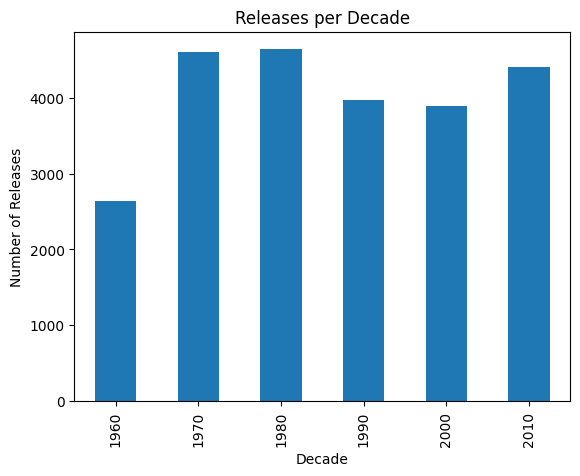

In [43]:
df["decade"] = (df["year"] // 10 * 10).astype("Int64")  # handle NaN safely
releases_per_decade = df["decade"].value_counts().sort_index()

# Bar plot of releases per decade
releases_per_decade.plot(kind="bar")
plt.xlabel("Decade")
plt.ylabel("Number of Releases")
plt.title("Releases per Decade")
plt.show()


Releases per genre, using genre_multi_hot_cols.

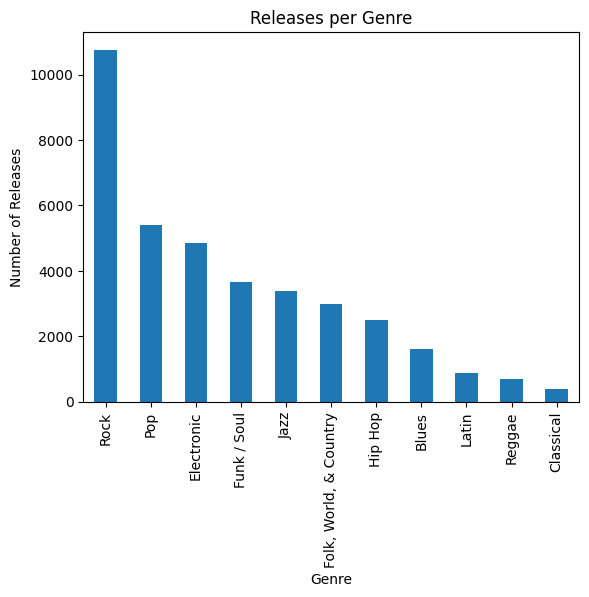

In [44]:
releases_per_genre = df[genre_multi_hot_cols].sum().sort_values(ascending=False)
releases_per_genre.plot(kind="bar")
plt.xlabel("Genre")
plt.ylabel("Number of Releases")
plt.title("Releases per Genre")
plt.xticks(
    ticks=range(len(releases_per_genre)),
    labels=[genre.split("_")[1] for genre in releases_per_genre.index]
)
plt.show()

Releases per decade × genre: cross-tab of genres and decades.

In [45]:
decade_genre_crosstab = df.groupby("decade")[genre_multi_hot_cols].sum()
decade_genre_crosstab.loc["Total"] = decade_genre_crosstab.sum()
decade_genre_crosstab["Total"] = decade_genre_crosstab.sum(axis=1)
decade_genre_crosstab


,genre_Blues,genre_Classical,genre_Electronic,"genre_Folk, World, & Country",genre_Funk / Soul,genre_Hip Hop,genre_Jazz,genre_Latin,genre_Pop,genre_Reggae,genre_Rock,Total
decade,,,,,,,,,,,,
1960,301,33,22,428,434,0,884,118,639,16,945,3820
1970,445,65,350,746,982,0,928,284,897,161,2005,6863
1980,213,91,1150,465,906,186,643,172,1062,233,1921,7042
1990,204,61,1092,278,405,772,323,129,771,90,1800,5925
2000,172,50,1113,371,378,785,264,112,845,98,1939,6127
2010,270,87,1134,702,566,766,336,59,1192,109,2144,7365
Total,1605,387,4861,2990,3671,2509,3378,874,5406,707,10754,37142


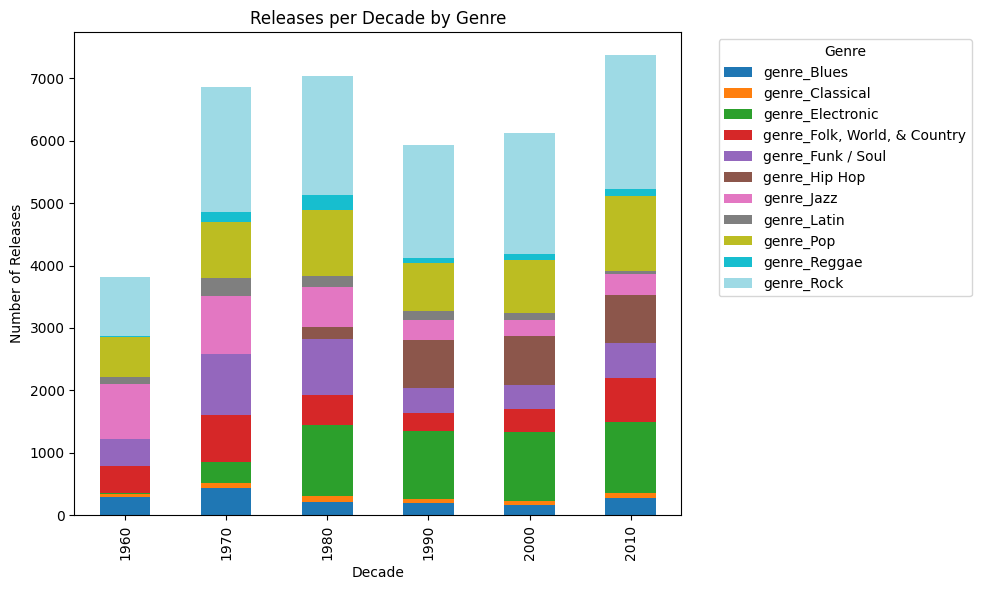

In [46]:
import matplotlib.pyplot as plt

# Drop the "Total" column to avoid double-counting
decade_genre_crosstab_no_total = decade_genre_crosstab.drop(columns="Total", errors="ignore").iloc[:-1,:]

# Plot stacked bar chart
ax = decade_genre_crosstab_no_total.plot(
    kind="bar",
    stacked=True,
    figsize=(10,6),
    colormap="tab20"   # You can try "tab20c", "Set3", etc.
)

plt.title("Releases per Decade by Genre")
plt.xlabel("Decade")
plt.ylabel("Number of Releases")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


We can observe the fact that a release can have multiple genres, and hence the dataset is not evenly distributed by genres anymore, as we did when sampling and creating the data pool and as we observed with distribution of releases per decade. The dataset is now representative of the real market of music. The earlier balanced sampling by decade and genre was only part of the strategy used to construct the data pool, from which most of the current dataset for analysis is derived, and we only had into account one genre out of the hole list of genres a release can have.

Average number of genres per release: sum over genre_multi_hot_cols.

Average number of formats per release: sum over format_multi_hot_cols.

In [47]:
genres_per_release = df[genre_multi_hot_cols].sum(axis=1)
avg_genres_per_release = genres_per_release.mean()
print(f"Average number of genres per release: {avg_genres_per_release}")
print("Summary of genres per release:")
print(genres_per_release.describe())
print("")

formats_per_release = df[format_multi_hot_cols].sum(axis=1)
avg_formats_per_release = formats_per_release.mean()
print(f"Average number of formats per release: {avg_formats_per_release}")
print("Summary of formats per release:")
print(formats_per_release.describe())

Average number of genres per release: 1.5391819651071237
Summary of genres per release:
count    24131.000000
mean         1.539182
std          0.741681
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          7.000000
dtype: float64

Average number of formats per release: 2.085947536364013
Summary of formats per release:
count    24131.000000
mean         2.085948
std          0.773198
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          5.000000
dtype: float64


## Phase 2: Statistical Summaries & Distributions

Summary statistics for each group of columns

In [48]:
df[[col for col in colors_cols if ("mean" in col) or ("std" in col)]].describe()

,dominant_colors_L_mean,dominant_colors_L_std,dominant_colors_a_mean,dominant_colors_a_std,dominant_colors_b_mean,dominant_colors_b_std,dominant_colors_chroma_mean,dominant_colors_chroma_std,prominent_colors_L_mean,prominent_colors_L_std,prominent_colors_a_mean,prominent_colors_a_std,prominent_colors_b_mean,prominent_colors_b_std,prominent_colors_chroma_mean,prominent_colors_chroma_std
count,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000
mean,45.642711,23.310928,5.666609,8.805909,7.415569,11.836349,17.252214,12.365347,52.181502,23.003822,10.855536,15.798540,15.353942,19.405505,30.287966,18.404940
std,19.110456,7.183496,9.908991,6.838373,13.240665,7.926773,13.309435,7.756085,8.819108,5.793120,11.283313,9.680136,14.995485,10.475220,14.226586,8.766799
min,1.739932,0.162349,-56.186852,0.000143,-83.982608,0.000446,0.000234,0.000474,11.632674,0.540122,-54.845980,0.000000,-60.328191,0.000731,0.002012,0.000421
25%,31.423430,18.321192,0.125596,3.600684,0.157667,6.035935,7.810996,6.604441,46.356216,19.103011,2.692148,8.111117,5.499133,11.910917,20.142932,12.239166
50%,44.934477,23.001307,3.529810,7.287910,5.748899,10.539049,14.088450,11.273740,52.369791,23.331483,10.259709,14.959494,15.616271,18.581439,30.108992,18.477505
75%,58.860193,27.974306,9.092590,12.427733,13.631513,16.094618,23.126284,16.988911,58.107542,27.183633,18.476593,22.771049,25.184980,25.985262,40.122608,24.545312
max,98.893995,48.752231,75.583806,60.337429,89.543494,67.215671,124.647177,54.874299,94.456313,42.986998,66.362123,66.353552,69.411620,79.805731,105.239292,51.232538


In [49]:
df[visual_complexity_cols].describe()

,vf_edge_density,vf_orientation_entropy,vf_pixel_intensity_entropy,vf_glcm_contrast,vf_glcm_homogeneity,vf_glcm_energy,vf_glcm_correlation,vf_glcm_entropy,vf_lbp_entropy,vf_lbp_energy,vf_visual_complexity
count,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000
mean,0.047060,0.900312,0.817551,0.013729,0.655803,0.259112,0.939872,0.566443,0.927241,0.147127,0.504605
std,0.054666,0.078802,0.148175,0.010967,0.125215,0.169282,0.040025,0.157578,0.100762,0.087242,0.073125
min,0.000000,0.030943,0.099899,0.000016,0.122433,0.037776,0.587536,0.000000,0.167358,0.103653,0.109102
25%,0.000000,0.857381,0.766501,0.006701,0.574735,0.139486,0.922994,0.480433,0.931377,0.111052,0.460254
50%,0.028395,0.907137,0.864781,0.011005,0.661349,0.201545,0.949144,0.589151,0.963318,0.117447,0.509130
75%,0.078616,0.952720,0.919333,0.017565,0.743032,0.323784,0.967922,0.677914,0.976383,0.134868,0.554091
max,0.357075,1.143843,0.995167,0.229488,0.992914,0.959139,0.999267,0.991374,0.992267,0.870081,0.746886


In [50]:
df[face_cols+text_cols].describe()

,vf_face_summary_n_faces,vf_face_summary_average_relative_size,vf_largest_face_relative_size,vf_text_summary_n_texts,vf_text_summary_average_relative_size,vf_largest_text_relative_size
count,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000,24131.000000
mean,1.225930,0.057433,0.048864,2.828438,0.128926,0.086601
std,2.814786,0.121519,0.110897,3.005164,0.142280,0.109210
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.299697,0.041650,0.026112
50%,0.554533,0.009898,0.005784,1.894773,0.088391,0.054560
75%,1.174701,0.054911,0.039440,3.503961,0.166659,0.106038
max,121.141542,1.926175,0.996004,54.475242,1.978297,1.053036


Histograms

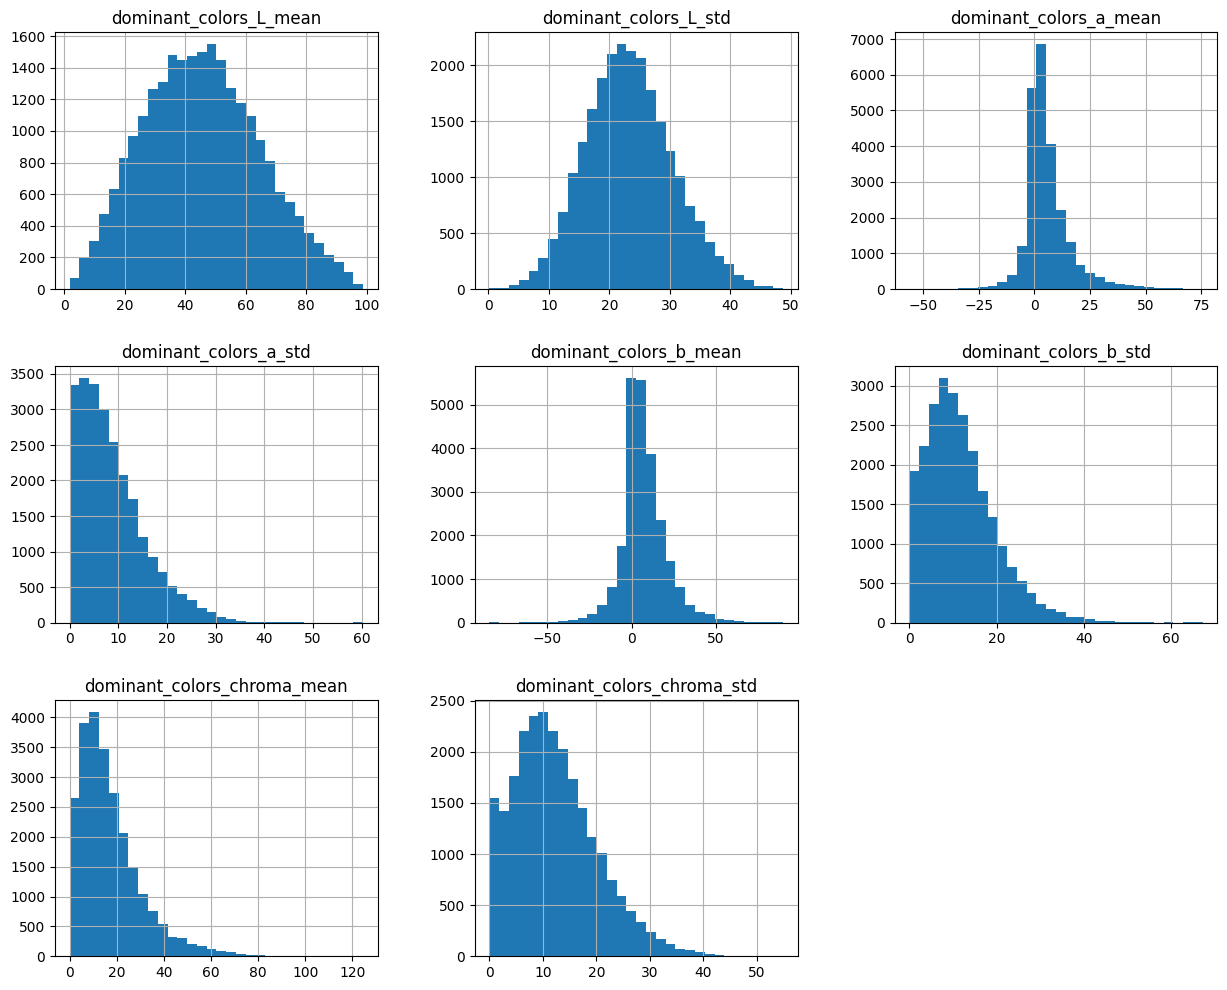

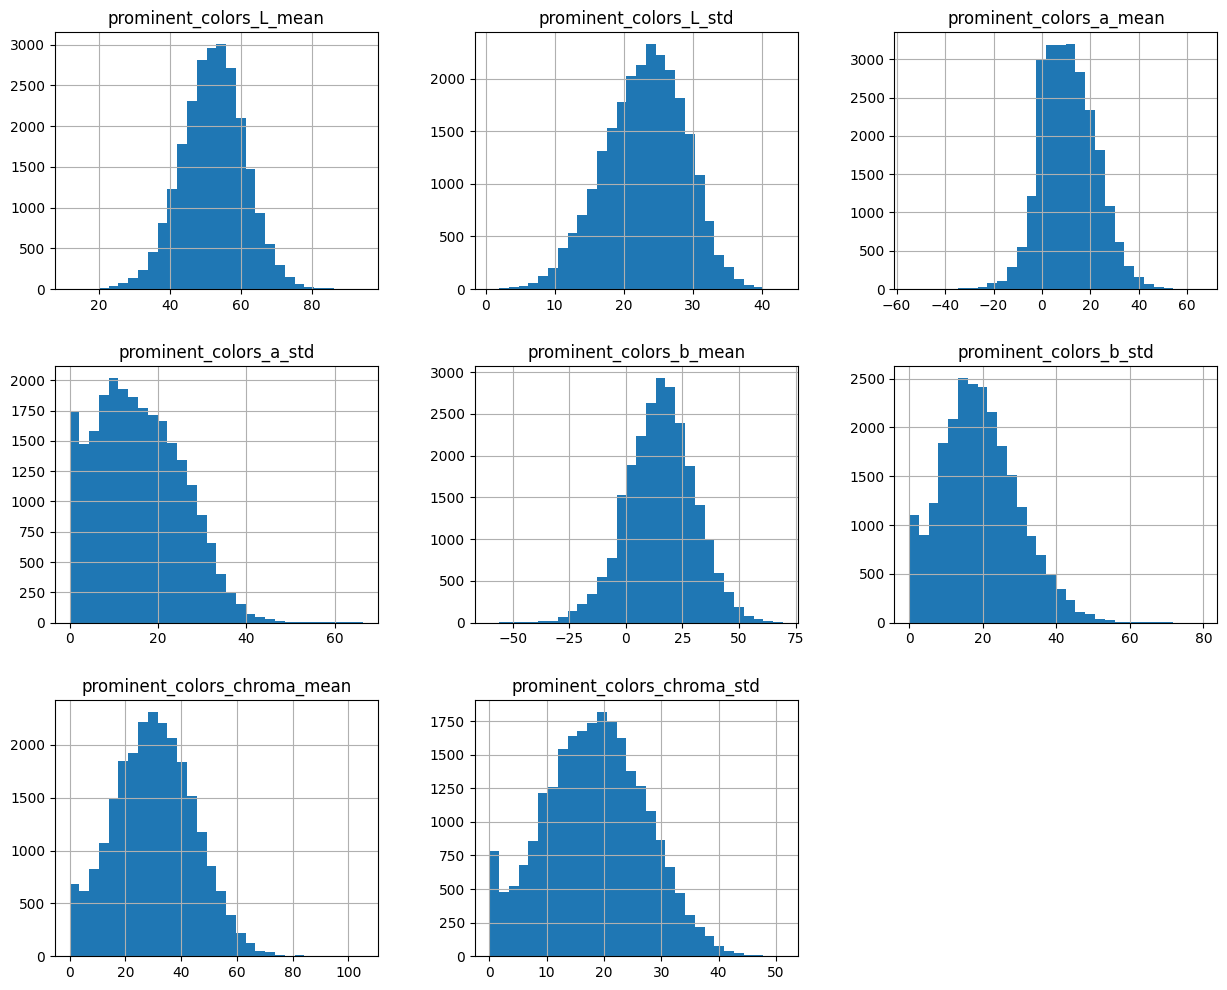

In [51]:
df[[col for col in colors_cols if (("mean" in col) or ("std" in col)) and ("dominant" in col)]].hist(bins=30, figsize=(15, 12))
plt.show()

df[[col for col in colors_cols if (("mean" in col) or ("std" in col)) and ("prominent" in col)]].hist(bins=30, figsize=(15, 12))
plt.show()

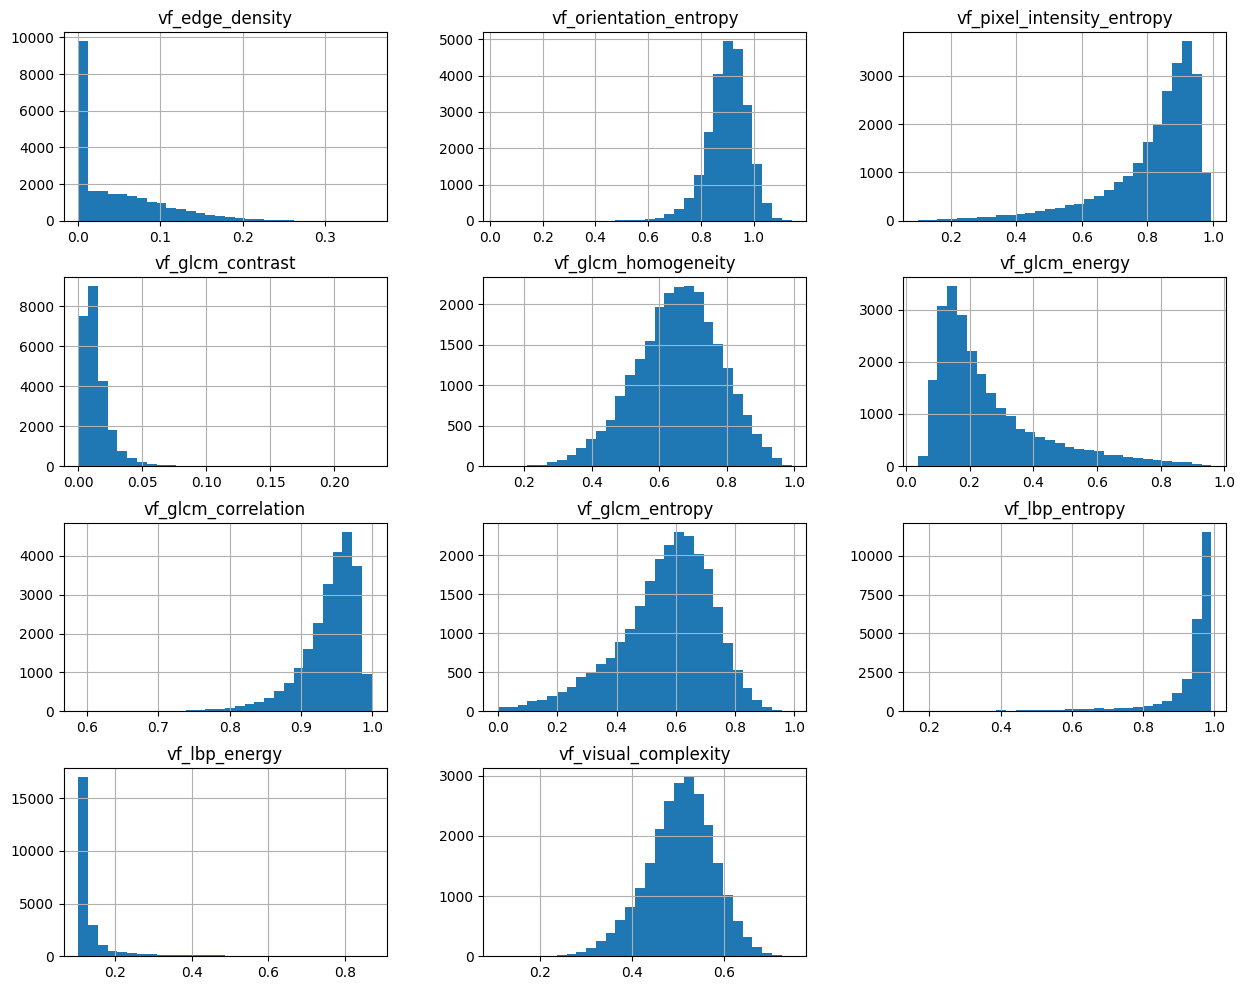

In [52]:
df[visual_complexity_cols].hist(bins=30, figsize=(15, 12))
plt.show()

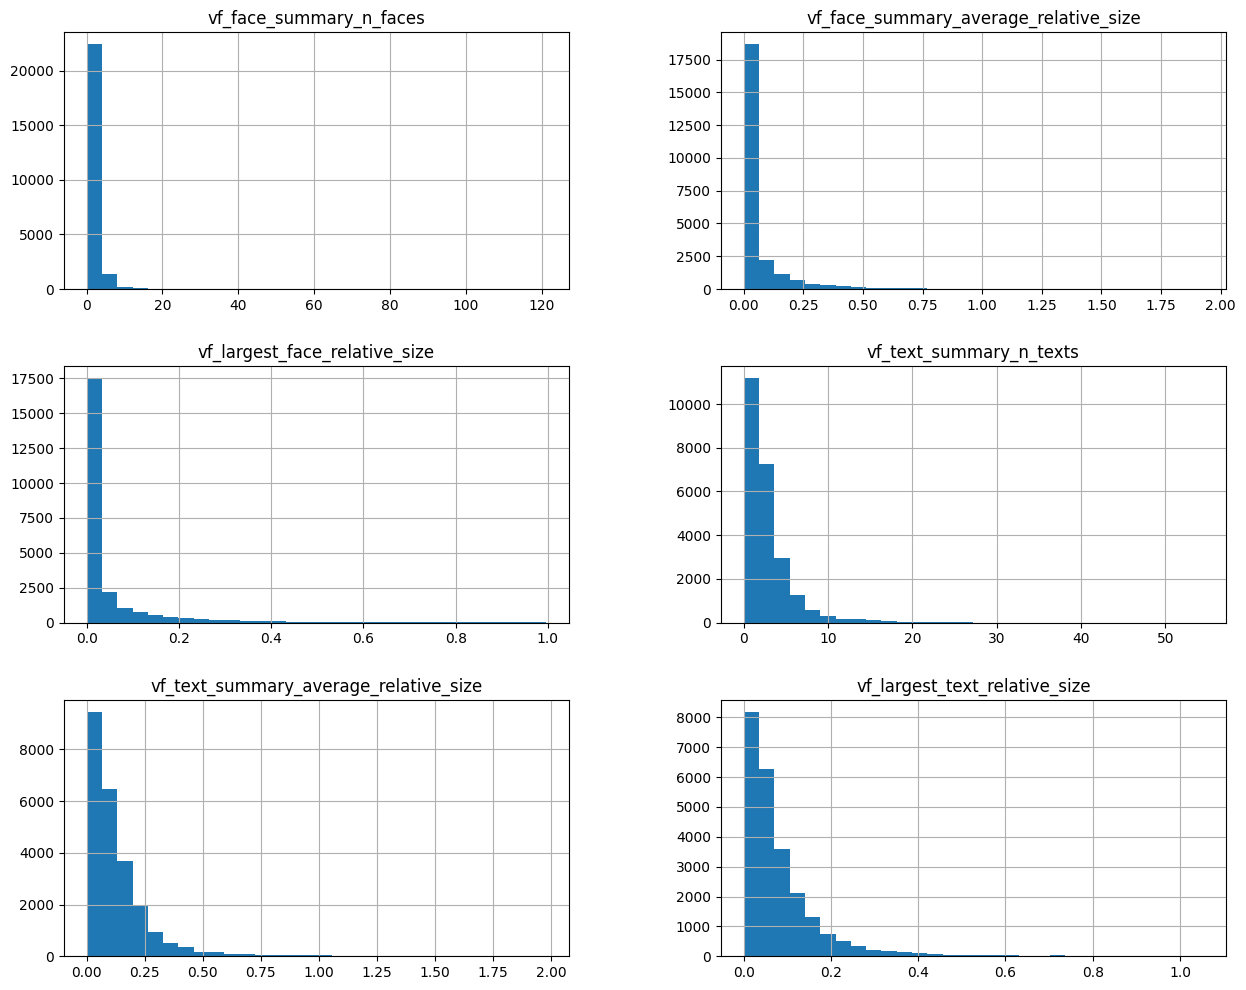

In [53]:
df[face_cols+text_cols].hist(bins=30, figsize=(15, 12))
plt.show()

## Phase 3: Correlations

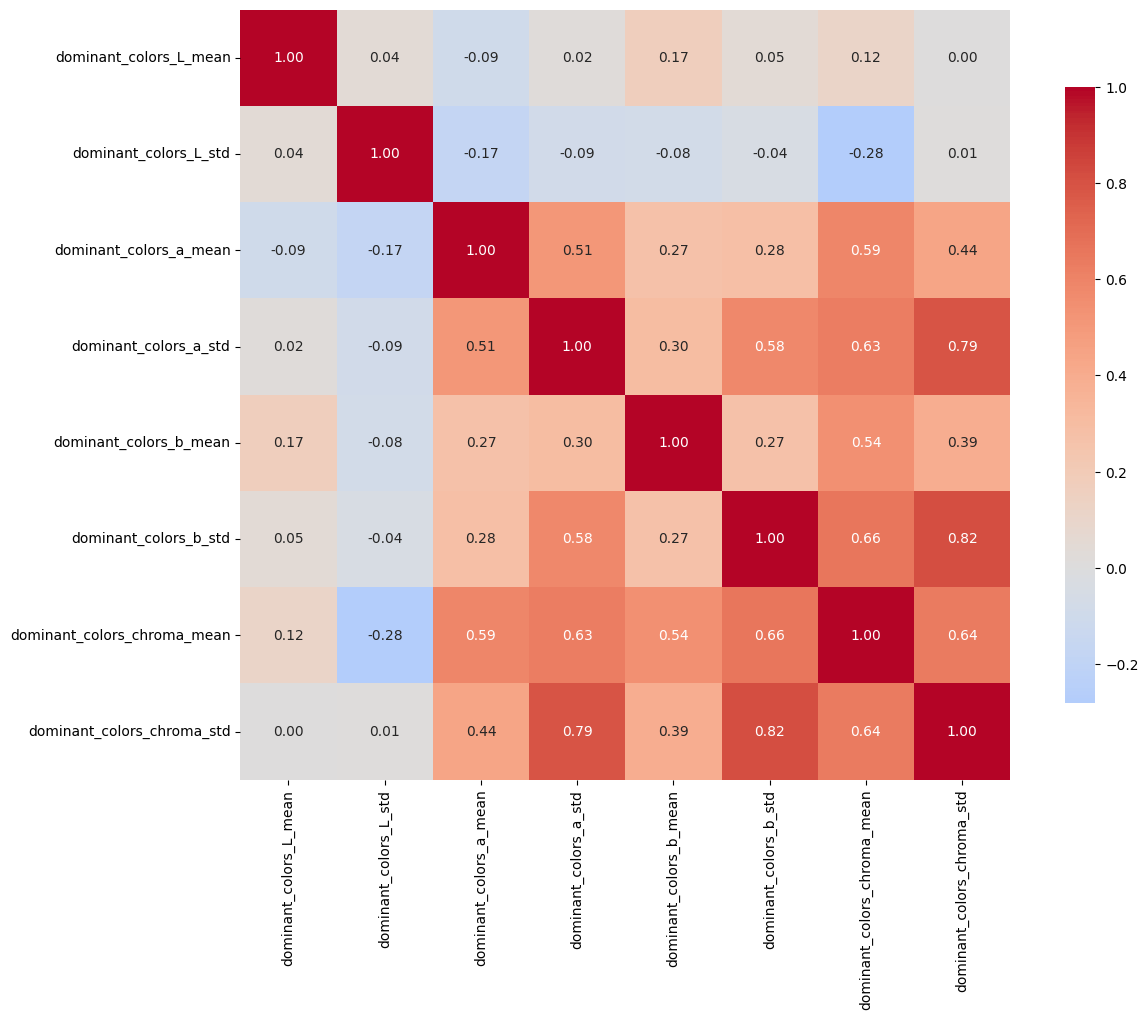

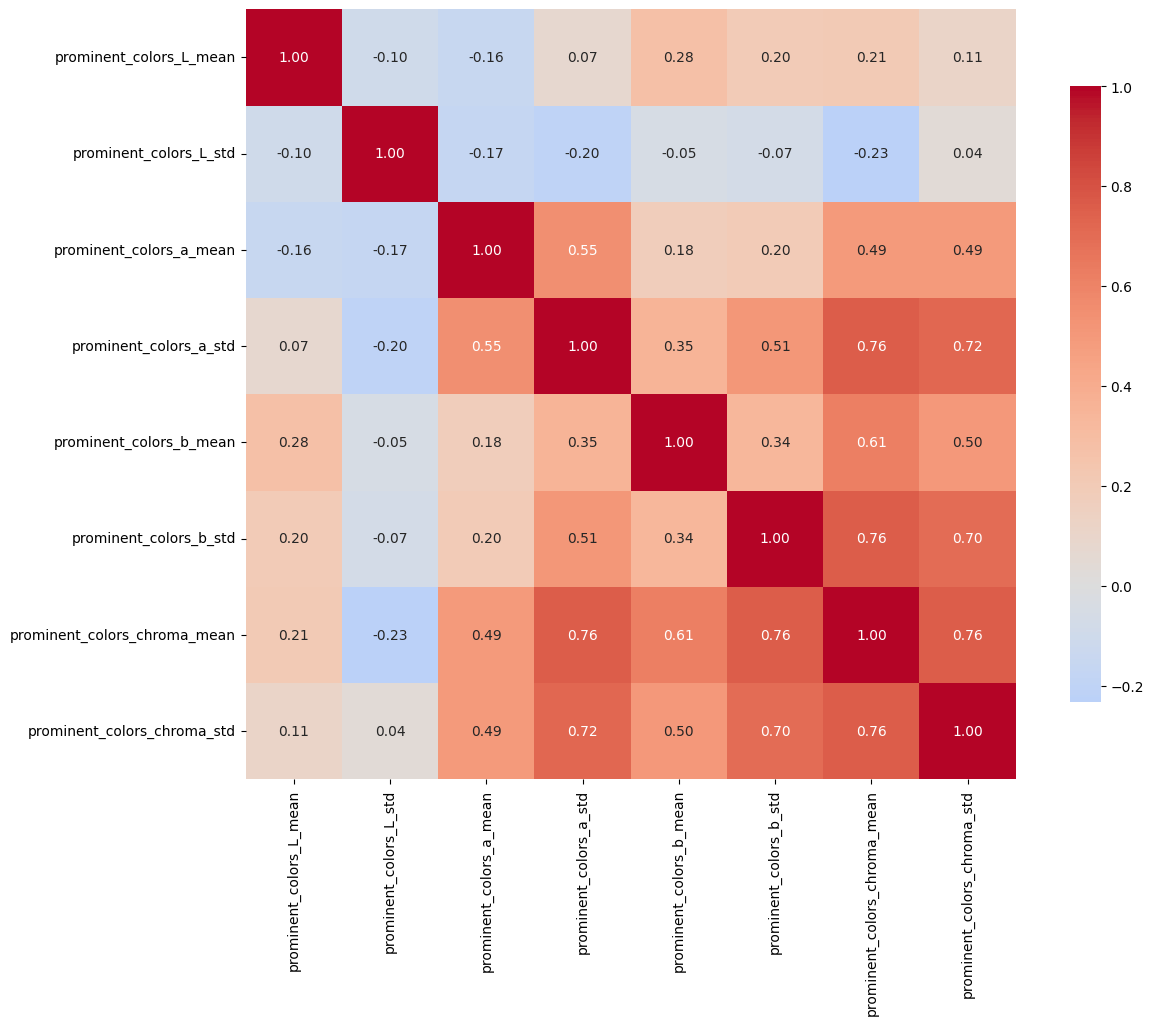

In [54]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    df[[col for col in colors_cols if (("mean" in col) or ("std" in col)) and ("dominant" in col)]].corr(),
    annot=True,      # show correlation values
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.show()

plt.figure(figsize=(14, 10))
sns.heatmap(
    df[[col for col in colors_cols if (("mean" in col) or ("std" in col)) and ("prominent" in col)]].corr(),
    annot=True,      # show correlation values
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.show()

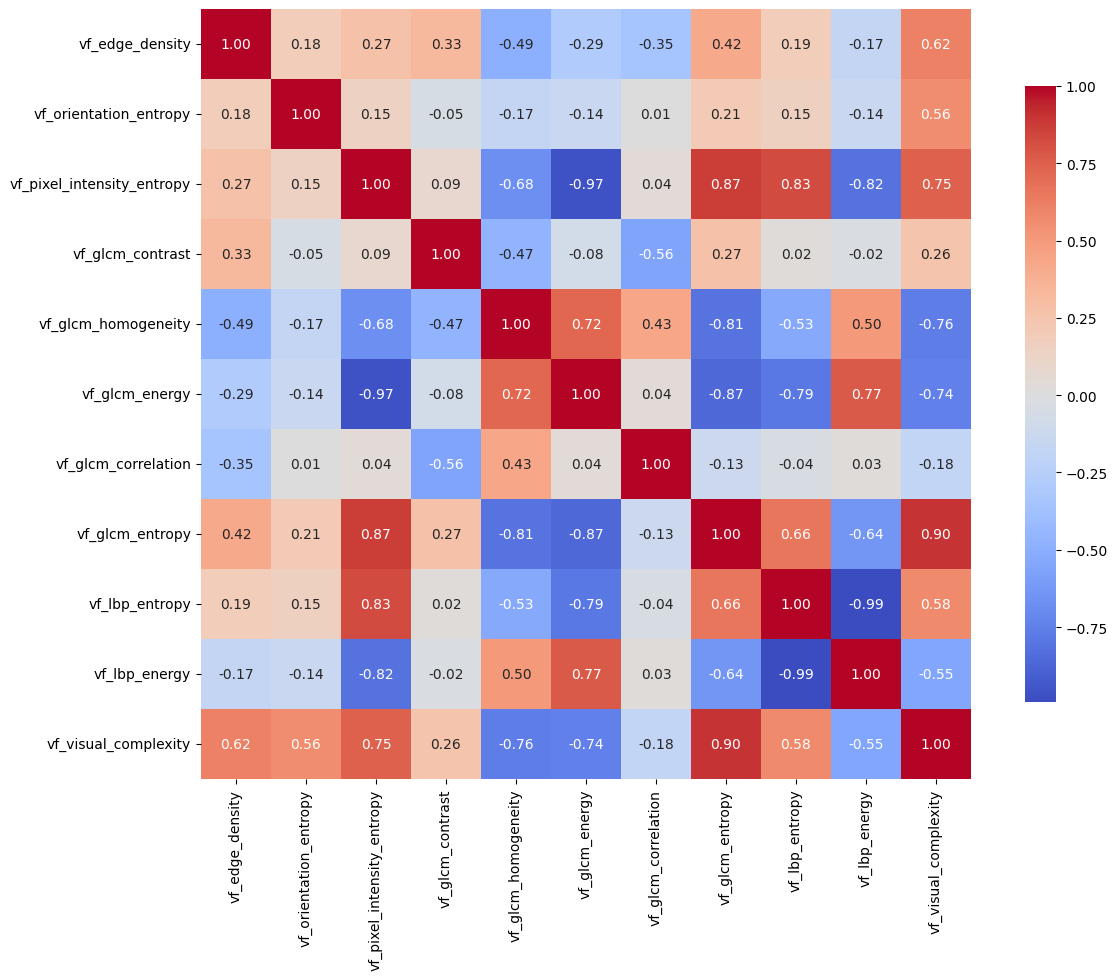

In [55]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    df[visual_complexity_cols].corr(),
    annot=True,      # show correlation values
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.show()

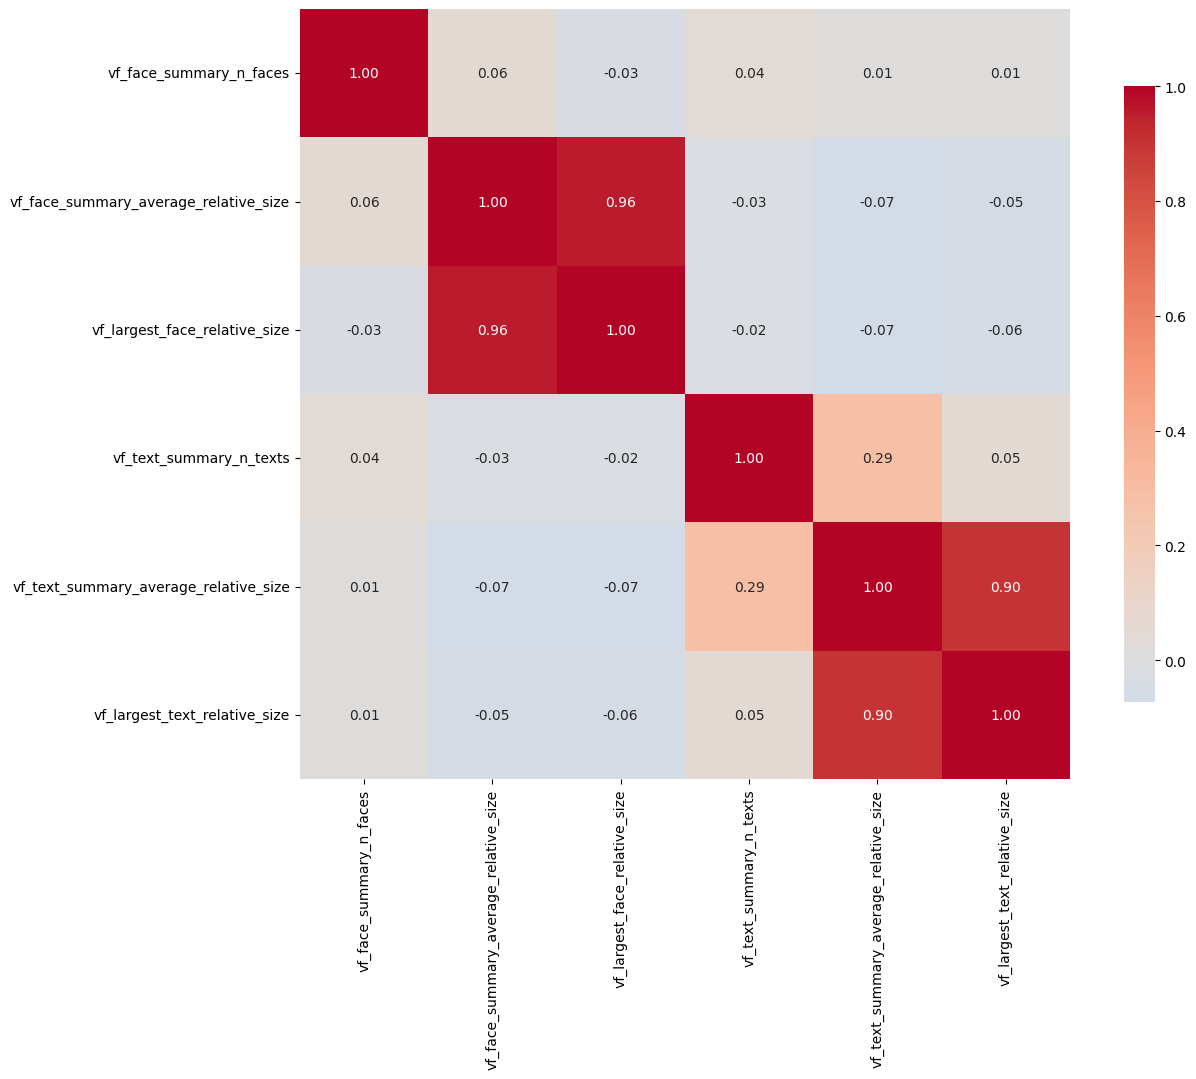

In [56]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    df[face_cols+text_cols].corr(),
    annot=True,      # show correlation values
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8}
)
plt.show()

## Phase 4: Genre-Focused Analyses

Goal: Explore how genres differ in visual properties.

Brightness/saturation by genre: group colors_cols summaries by genre_multi_hot_cols.

In [57]:
# Pick color summary features only
color_summary_cols = [c for c in colors_cols if any(stat in c for stat in ["_mean", "_std"])]

# Average brightness/saturation per genre
brightness_saturation_by_genre = {}
for genre in genre_multi_hot_cols:
    mask = df[genre] == 1
    brightness_saturation_by_genre[genre] = df.loc[mask, color_summary_cols].mean()

brightness_saturation_by_genre = pd.DataFrame(brightness_saturation_by_genre).T
brightness_saturation_by_genre

,dominant_colors_L_mean,dominant_colors_L_std,dominant_colors_a_mean,dominant_colors_a_std,dominant_colors_b_mean,dominant_colors_b_std,dominant_colors_chroma_mean,dominant_colors_chroma_std,prominent_colors_L_mean,prominent_colors_L_std,prominent_colors_a_mean,prominent_colors_a_std,prominent_colors_b_mean,prominent_colors_b_std,prominent_colors_chroma_mean,prominent_colors_chroma_std
genre_Blues,43.858709,23.411559,6.015587,8.576511,7.642574,11.781771,17.189034,12.279815,52.088439,22.738569,11.031674,15.412175,15.783907,19.529493,30.311599,18.194713
genre_Classical,46.626870,22.070954,4.652726,7.395334,5.914233,11.255949,15.952780,11.279669,52.595726,23.105066,9.272811,14.210508,14.696093,19.575360,29.210985,18.168471
genre_Electronic,47.246274,23.167072,5.443519,9.043418,6.166906,12.075620,17.626528,12.536891,52.414373,23.039534,10.400505,15.933269,13.638932,19.582975,30.416332,18.223066
"genre_Folk, World, & Country",46.608846,22.735863,4.934641,7.701132,8.477905,10.950998,16.561498,11.164530,52.237796,22.617205,9.474236,14.166007,15.545307,18.128437,28.312949,17.030572
genre_Funk / Soul,45.843820,23.339558,6.906853,9.402575,7.723838,12.190112,17.830675,12.891002,52.609293,22.501485,12.287176,16.606334,15.890600,19.969864,31.378882,18.887617
genre_Hip Hop,43.496139,24.732881,5.522587,8.889186,7.280176,12.091382,16.444387,12.971910,51.369109,24.301017,10.786851,16.105102,15.850860,19.771945,30.378170,19.392632
genre_Jazz,45.867294,23.285830,5.480746,8.749358,7.157457,11.709467,17.040959,12.213916,52.578078,22.933741,10.599030,15.914832,14.738928,19.613046,30.234786,18.320017
genre_Latin,47.683564,23.379322,6.631206,9.982201,9.672360,13.371369,19.721699,13.817552,53.323762,22.691756,12.066259,17.410153,18.055238,20.945686,33.136279,19.733251
genre_Pop,48.335278,23.474058,5.695719,8.726091,7.252358,11.706001,17.111915,12.189155,52.650637,22.933773,11.127921,15.699382,14.809188,19.224983,29.902557,18.179526
genre_Reggae,47.966188,23.745438,5.636354,10.917671,11.225915,14.018752,20.591443,14.821503,53.509888,22.623831,10.791806,19.554540,21.168240,21.629872,35.468714,21.003489


In [58]:
# Coeficiente de variación por columna
cv_cols = brightness_saturation_by_genre.std() / brightness_saturation_by_genre.mean()
brightness_saturation_by_genre.loc["CoefVar"] = cv_cols
# Coeficiente de variación por fila
brightness_saturation_by_genre["CoefVar_row"] = brightness_saturation_by_genre.std(axis=1) / brightness_saturation_by_genre.mean(axis=1)
brightness_saturation_by_genre

,dominant_colors_L_mean,dominant_colors_L_std,dominant_colors_a_mean,dominant_colors_a_std,dominant_colors_b_mean,dominant_colors_b_std,dominant_colors_chroma_mean,dominant_colors_chroma_std,prominent_colors_L_mean,prominent_colors_L_std,prominent_colors_a_mean,prominent_colors_a_std,prominent_colors_b_mean,prominent_colors_b_std,prominent_colors_chroma_mean,prominent_colors_chroma_std,CoefVar_row
genre_Blues,43.858709,23.411559,6.015587,8.576511,7.642574,11.781771,17.189034,12.279815,52.088439,22.738569,11.031674,15.412175,15.783907,19.529493,30.311599,18.194713,0.648712
genre_Classical,46.626870,22.070954,4.652726,7.395334,5.914233,11.255949,15.952780,11.279669,52.595726,23.105066,9.272811,14.210508,14.696093,19.575360,29.210985,18.168471,0.714414
genre_Electronic,47.246274,23.167072,5.443519,9.043418,6.166906,12.075620,17.626528,12.536891,52.414373,23.039534,10.400505,15.933269,13.638932,19.582975,30.416332,18.223066,0.679786
"genre_Folk, World, & Country",46.608846,22.735863,4.934641,7.701132,8.477905,10.950998,16.561498,11.164530,52.237796,22.617205,9.474236,14.166007,15.545307,18.128437,28.312949,17.030572,0.697348
genre_Funk / Soul,45.843820,23.339558,6.906853,9.402575,7.723838,12.190112,17.830675,12.891002,52.609293,22.501485,12.287176,16.606334,15.890600,19.969864,31.378882,18.887617,0.635074
genre_Hip Hop,43.496139,24.732881,5.522587,8.889186,7.280176,12.091382,16.444387,12.971910,51.369109,24.301017,10.786851,16.105102,15.850860,19.771945,30.378170,19.392632,0.636544
genre_Jazz,45.867294,23.285830,5.480746,8.749358,7.157457,11.709467,17.040959,12.213916,52.578078,22.933741,10.599030,15.914832,14.738928,19.613046,30.234786,18.320017,0.669515
genre_Latin,47.683564,23.379322,6.631206,9.982201,9.672360,13.371369,19.721699,13.817552,53.323762,22.691756,12.066259,17.410153,18.055238,20.945686,33.136279,19.733251,0.614389
genre_Pop,48.335278,23.474058,5.695719,8.726091,7.252358,11.706001,17.111915,12.189155,52.650637,22.933773,11.127921,15.699382,14.809188,19.224983,29.902557,18.179526,0.678846
genre_Reggae,47.966188,23.745438,5.636354,10.917671,11.225915,14.018752,20.591443,14.821503,53.509888,22.623831,10.791806,19.554540,21.168240,21.629872,35.468714,21.003489,0.594932


Visual complexity by genre: group visual_complexity_cols.

In [59]:
visual_complexity_by_genre = {}
for genre in genre_multi_hot_cols:
    mask = df[genre] == 1
    visual_complexity_by_genre[genre] = df.loc[mask, visual_complexity_cols].mean()

visual_complexity_by_genre = pd.DataFrame(visual_complexity_by_genre).T
visual_complexity_by_genre

,vf_edge_density,vf_orientation_entropy,vf_pixel_intensity_entropy,vf_glcm_contrast,vf_glcm_homogeneity,vf_glcm_energy,vf_glcm_correlation,vf_glcm_entropy,vf_lbp_entropy,vf_lbp_energy,vf_visual_complexity
genre_Blues,0.051487,0.906610,0.831054,0.014325,0.645633,0.243726,0.937524,0.588022,0.938813,0.137939,0.515373
genre_Classical,0.043137,0.892608,0.794957,0.013400,0.662894,0.282076,0.931544,0.541739,0.916203,0.155856,0.492495
genre_Electronic,0.037327,0.884849,0.789240,0.012848,0.677331,0.289376,0.942776,0.526060,0.908095,0.162829,0.482745
"genre_Folk, World, & Country",0.051243,0.904832,0.829777,0.013085,0.649072,0.245630,0.940006,0.578667,0.934771,0.141021,0.511580
genre_Funk / Soul,0.048345,0.906996,0.831659,0.012736,0.664214,0.246825,0.944550,0.578219,0.933131,0.141675,0.511187
genre_Hip Hop,0.030832,0.879538,0.811280,0.015891,0.650141,0.266431,0.938923,0.550236,0.916546,0.155592,0.486869
genre_Jazz,0.052824,0.906844,0.815976,0.013149,0.670004,0.262170,0.940779,0.570199,0.931803,0.143226,0.509955
genre_Latin,0.052855,0.915268,0.831719,0.012769,0.658992,0.246758,0.944883,0.582025,0.935222,0.139963,0.516716
genre_Pop,0.042264,0.900666,0.820448,0.012301,0.670995,0.260600,0.946656,0.560021,0.924961,0.148437,0.500983
genre_Reggae,0.054778,0.906393,0.836863,0.016417,0.631790,0.236252,0.933541,0.593903,0.938151,0.137971,0.518358


Faces & text by genre: averages of face_cols and text_cols.

In [60]:
faces_text_by_genre = {}
for genre in genre_multi_hot_cols:
    mask = df[genre] == 1
    faces_text_by_genre[genre] = df.loc[mask, face_cols + text_cols].mean()

faces_text_by_genre = pd.DataFrame(faces_text_by_genre).T
faces_text_by_genre

,vf_face_summary_n_faces,vf_face_summary_average_relative_size,vf_largest_face_relative_size,vf_text_summary_n_texts,vf_text_summary_average_relative_size,vf_largest_text_relative_size
genre_Blues,1.222586,0.056668,0.049997,3.317637,0.147574,0.093497
genre_Classical,0.972217,0.047587,0.039549,4.386764,0.129716,0.072629
genre_Electronic,0.899156,0.049793,0.042189,2.252607,0.113701,0.081292
"genre_Folk, World, & Country",1.206127,0.058502,0.052671,3.082393,0.118584,0.075188
genre_Funk / Soul,1.704705,0.075684,0.064362,2.925593,0.129830,0.089617
genre_Hip Hop,1.226412,0.063242,0.052474,2.839294,0.147473,0.098707
genre_Jazz,1.132950,0.064398,0.056554,3.806053,0.132208,0.081597
genre_Latin,1.348040,0.080818,0.071757,2.847296,0.118842,0.079385
genre_Pop,1.335947,0.075173,0.064862,2.773181,0.119666,0.080760
genre_Reggae,1.630637,0.058451,0.049593,2.885486,0.153709,0.101149


In [61]:
# Coeficiente de variación por columna
cv_cols = faces_text_by_genre.std() / faces_text_by_genre.mean()
faces_text_by_genre.loc["CoefVar"] = cv_cols
# Coeficiente de variación por fila
faces_text_by_genre["CoefVar_row"] = faces_text_by_genre.std(axis=1) / faces_text_by_genre.mean(axis=1)
faces_text_by_genre

,vf_face_summary_n_faces,vf_face_summary_average_relative_size,vf_largest_face_relative_size,vf_text_summary_n_texts,vf_text_summary_average_relative_size,vf_largest_text_relative_size,CoefVar_row
genre_Blues,1.222586,0.056668,0.049997,3.317637,0.147574,0.093497,1.605702
genre_Classical,0.972217,0.047587,0.039549,4.386764,0.129716,0.072629,1.833538
genre_Electronic,0.899156,0.049793,0.042189,2.252607,0.113701,0.081292,1.548025
"genre_Folk, World, & Country",1.206127,0.058502,0.052671,3.082393,0.118584,0.075188,1.596044
genre_Funk / Soul,1.704705,0.075684,0.064362,2.925593,0.129830,0.089617,1.457920
genre_Hip Hop,1.226412,0.063242,0.052474,2.839294,0.147473,0.098707,1.525554
genre_Jazz,1.132950,0.064398,0.056554,3.806053,0.132208,0.081597,1.700154
genre_Latin,1.348040,0.080818,0.071757,2.847296,0.118842,0.079385,1.506177
genre_Pop,1.335947,0.075173,0.064862,2.773181,0.119666,0.080760,1.502306
genre_Reggae,1.630637,0.058451,0.049593,2.885486,0.153709,0.101149,1.461003


Genre co-occurrence: co-occurrence heatmap of genre_multi_hot_cols.

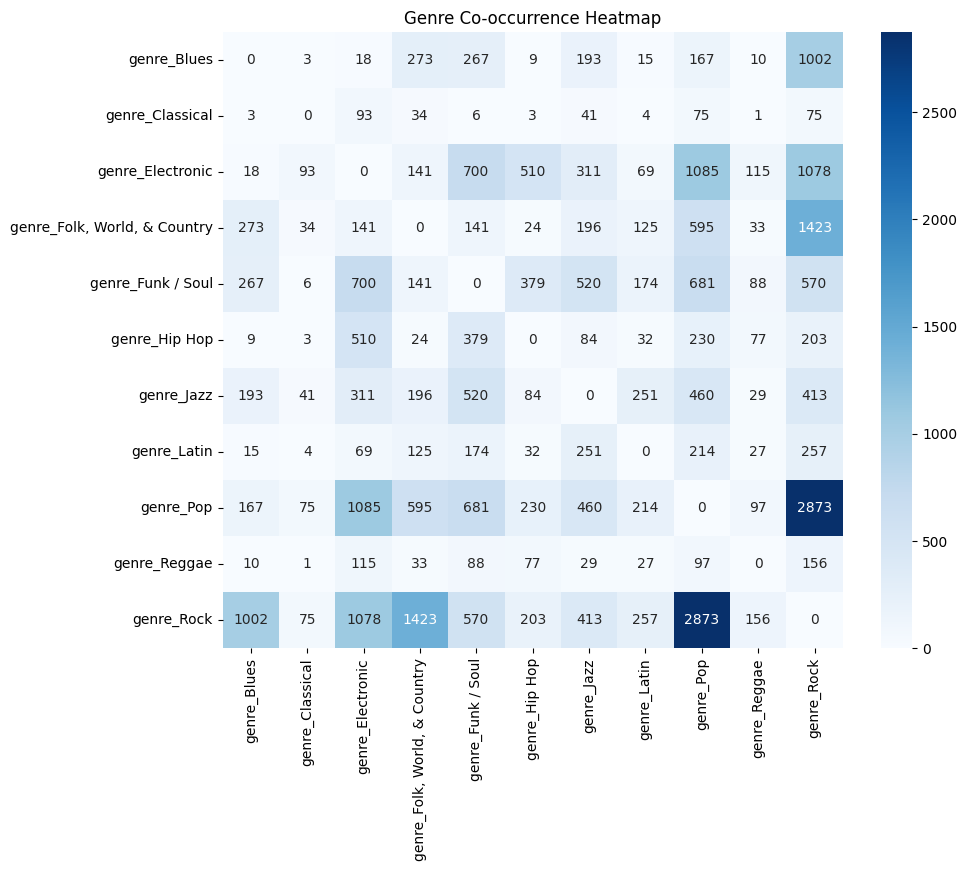

In [62]:
# Co-occurrence matrix
genre_cooccurrence = df[genre_multi_hot_cols].T.dot(df[genre_multi_hot_cols])

# Optionally set diagonal = 0 so self-counts don’t dominate
np.fill_diagonal(genre_cooccurrence.values, 0)

# Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(genre_cooccurrence, annot=True, fmt="d", cmap="Blues")
plt.title("Genre Co-occurrence Heatmap")
plt.show()


In [63]:
# Convert the co-occurrence DataFrame into long form
coocc_table = (
    genre_cooccurrence
    .where(np.triu(np.ones(genre_cooccurrence.shape), k=1).astype(bool))  # keep only upper triangle
    .stack()  # drop NaN and flatten
    .reset_index()
)

coocc_table.columns = ["genre_1", "genre_2", "count"]

# Sort by count descending
coocc_table = coocc_table.sort_values("count", ascending=False).reset_index(drop=True)

print(coocc_table.head(20))


                         genre_1                       genre_2   count
0                      genre_Pop                    genre_Rock  2873.0
1   genre_Folk, World, & Country                    genre_Rock  1423.0
2               genre_Electronic                     genre_Pop  1085.0
3               genre_Electronic                    genre_Rock  1078.0
4                    genre_Blues                    genre_Rock  1002.0
5               genre_Electronic             genre_Funk / Soul   700.0
6              genre_Funk / Soul                     genre_Pop   681.0
7   genre_Folk, World, & Country                     genre_Pop   595.0
8              genre_Funk / Soul                    genre_Rock   570.0
9              genre_Funk / Soul                    genre_Jazz   520.0
10              genre_Electronic                 genre_Hip Hop   510.0
11                    genre_Jazz                     genre_Pop   460.0
12                    genre_Jazz                    genre_Rock   413.0
13    

## Phase 5: Decade-Focused Analyses

Goal: Explore historical evolution of cover art.

Brightness & saturation by decade: trends in dominant_colors_L_mean, dominant_colors_chroma_mean.

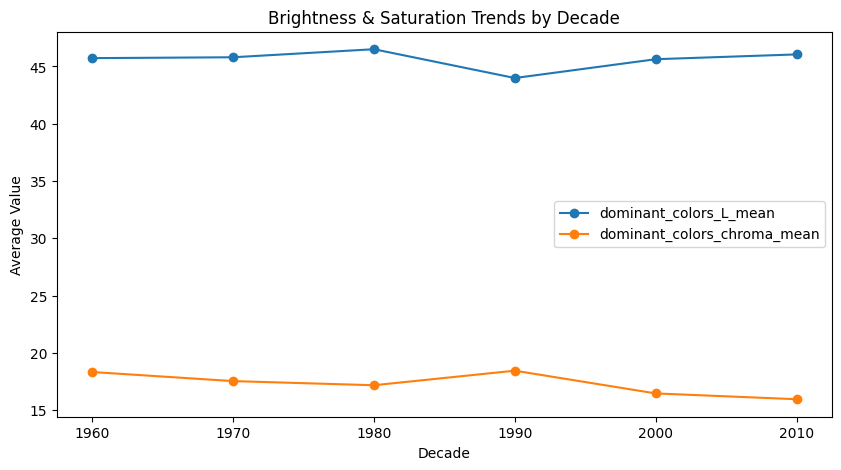

In [64]:
# Aggregate by decade
brightness_saturation_by_decade = (
    df.groupby("decade")[["dominant_colors_L_mean", "dominant_colors_chroma_mean"]]
    .mean()
    .reset_index()
)

# Plot trends
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
for col in ["dominant_colors_L_mean", "dominant_colors_chroma_mean"]:
    plt.plot(brightness_saturation_by_decade["decade"], brightness_saturation_by_decade[col], marker="o", label=col)

plt.title("Brightness & Saturation Trends by Decade")
plt.xlabel("Decade")
plt.ylabel("Average Value")
plt.legend()
plt.show()


Complexity trends: vf_visual_complexity and vf_edge_density over decades.

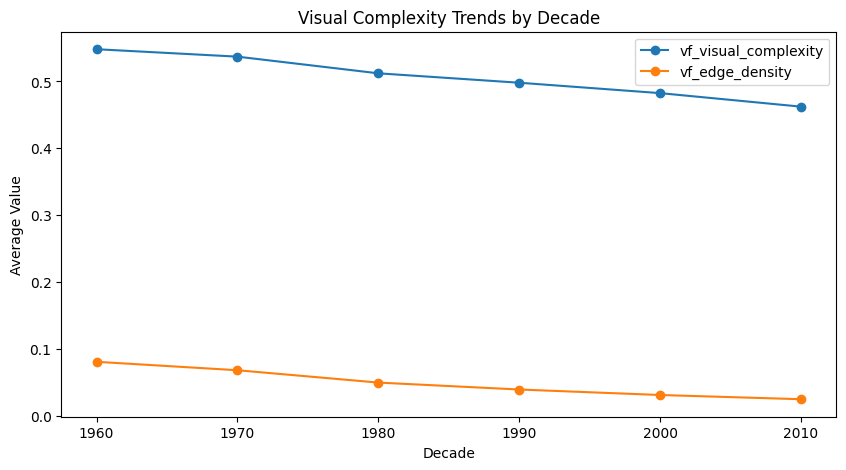

In [65]:
complexity_by_decade = (
    df.groupby("decade")[["vf_visual_complexity", "vf_edge_density"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
for col in ["vf_visual_complexity", "vf_edge_density"]:
    plt.plot(complexity_by_decade["decade"], complexity_by_decade[col], marker="o", label=col)

plt.title("Visual Complexity Trends by Decade")
plt.xlabel("Decade")
plt.ylabel("Average Value")
plt.legend()
plt.show()


Faces & text trends: vf_face_summary_n_faces, vf_text_summary_n_texts over time.

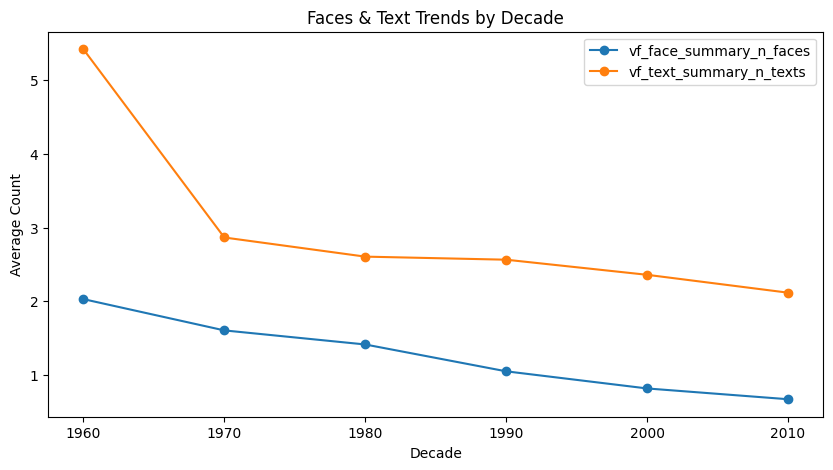

In [66]:
faces_text_by_decade = (
    df.groupby("decade")[["vf_face_summary_n_faces", "vf_text_summary_n_texts"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
for col in ["vf_face_summary_n_faces", "vf_text_summary_n_texts"]:
    plt.plot(faces_text_by_decade["decade"], faces_text_by_decade[col], marker="o", label=col)

plt.title("Faces & Text Trends by Decade")
plt.xlabel("Decade")
plt.ylabel("Average Count")
plt.legend()
plt.show()


Interactions: check if trends differ by genre (e.g., Hip Hop vs Classical).

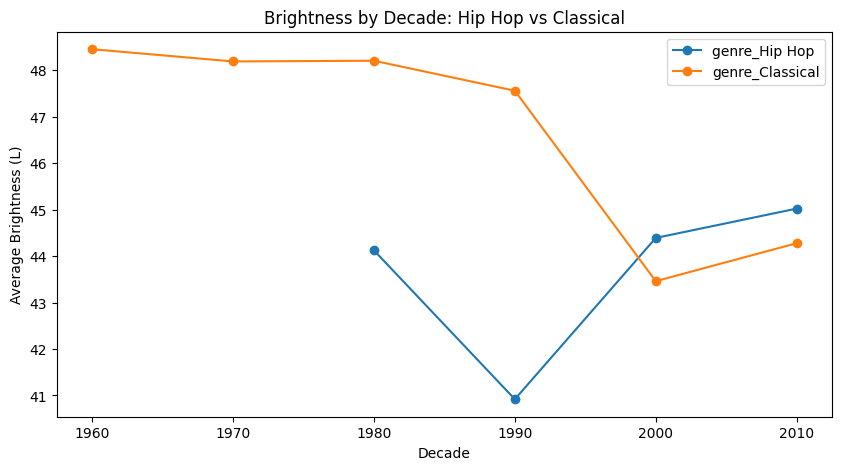

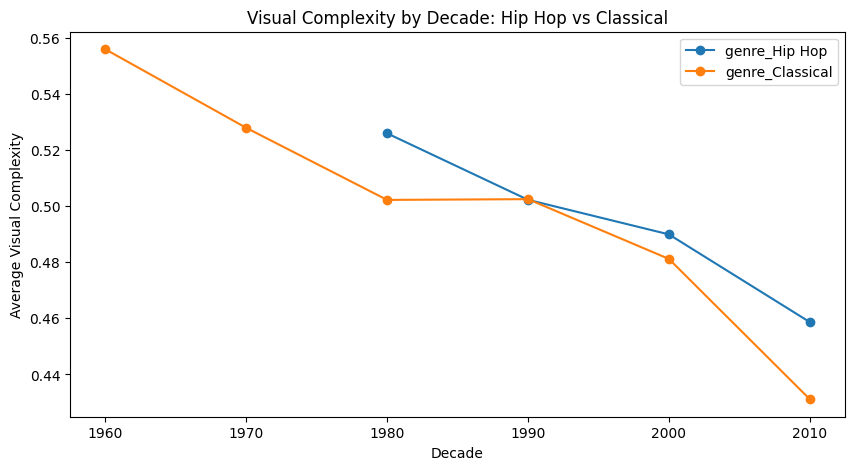

In [67]:
# Choose two genres to compare
genres_to_compare = ["genre_Hip Hop", "genre_Classical"]

interaction_brightness = (
    df.groupby(["decade"])[genres_to_compare + ["dominant_colors_L_mean"]]
    .apply(lambda g: {
        genre: g.loc[g[genre] == 1, "dominant_colors_L_mean"].mean()
        for genre in genres_to_compare
    })
)

interaction_complexity = (
    df.groupby(["decade"])[genres_to_compare + ["vf_visual_complexity"]]
    .apply(lambda g: {
        genre: g.loc[g[genre] == 1, "vf_visual_complexity"].mean()
        for genre in genres_to_compare
    })
)

# Convert results into DataFrames
interaction_brightness = pd.DataFrame(list(interaction_brightness), index=interaction_brightness.index)
interaction_complexity = pd.DataFrame(list(interaction_complexity), index=interaction_complexity.index)

# Plot brightness comparison
interaction_brightness.plot(marker="o", figsize=(10,5), title="Brightness by Decade: Hip Hop vs Classical")
plt.xlabel("Decade")
plt.ylabel("Average Brightness (L)")
plt.show()

# Plot complexity comparison
interaction_complexity.plot(marker="o", figsize=(10,5), title="Visual Complexity by Decade: Hip Hop vs Classical")
plt.xlabel("Decade")
plt.ylabel("Average Visual Complexity")
plt.show()


## Phase 6: Color-Specific Explorations

Color clustering: cluster all colors (Lab space, k≈8). Explain these cluster as something categorical explainable (like black, light blue) Represent covers as proportions per cluster → analyze distributions across genre/decade.

In [68]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# --- Collect Lab columns grouped per slot ---
lab_slots = []
for i in range(1, 6):
    lab_slots.append([f"dominant_colors_color_{i}_L",
                      f"dominant_colors_color_{i}_a",
                      f"dominant_colors_color_{i}_b"])
for i in range(1, 6):
    lab_slots.append([f"prominent_colors_color_{i}_L",
                      f"prominent_colors_color_{i}_a",
                      f"prominent_colors_color_{i}_b"])

n_samples = df.shape[0]
n_slots = len(lab_slots)  # should be 10

# --- Build a long dataframe: one row per (cover, slot) ---
all_colors_list = []
for slot_id, cols in enumerate(lab_slots):
    sub = df[cols].copy()
    sub.columns = ["L", "a", "b"]
    sub["slot"] = slot_id
    sub["cover_id"] = df.index
    all_colors_list.append(sub)

all_colors = pd.concat(all_colors_list, axis=0, ignore_index=True)

# --- Drop NaNs and cluster ---
mask = ~all_colors[["L", "a", "b"]].isna().any(axis=1)
valid_colors = all_colors.loc[mask, ["L", "a", "b"]].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(valid_colors)

k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# --- Assign labels back ---
all_colors.loc[mask, "cluster"] = labels

# --- Compute per-cover proportions ---
cluster_props = (
    all_colors.groupby("cover_id")["cluster"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Ensure all k clusters are present as columns
for i in range(k):
    if i not in cluster_props.columns:
        cluster_props[i] = 0

cluster_props = cluster_props.sort_index(axis=1)
cluster_props.columns = [f"color_cluster_{i}_prop" for i in cluster_props.columns]

# Merge back into df
df = pd.concat([df, cluster_props], axis=1)


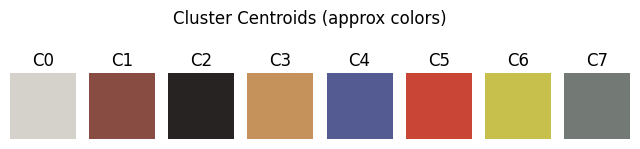

In [69]:
import matplotlib.pyplot as plt

# Centroids in Lab space → approximate RGB for visualization
from skimage.color import lab2rgb

centroids_lab = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_rgb = lab2rgb(centroids_lab[np.newaxis, :, :]).squeeze()

plt.figure(figsize=(8,2))
for i, rgb in enumerate(centroids_rgb):
    plt.subplot(1, k, i+1)
    plt.imshow(np.ones((10,10,3)) * rgb)
    plt.axis("off")
    plt.title(f"C{i}")
plt.suptitle("Cluster Centroids (approx colors)")
plt.show()


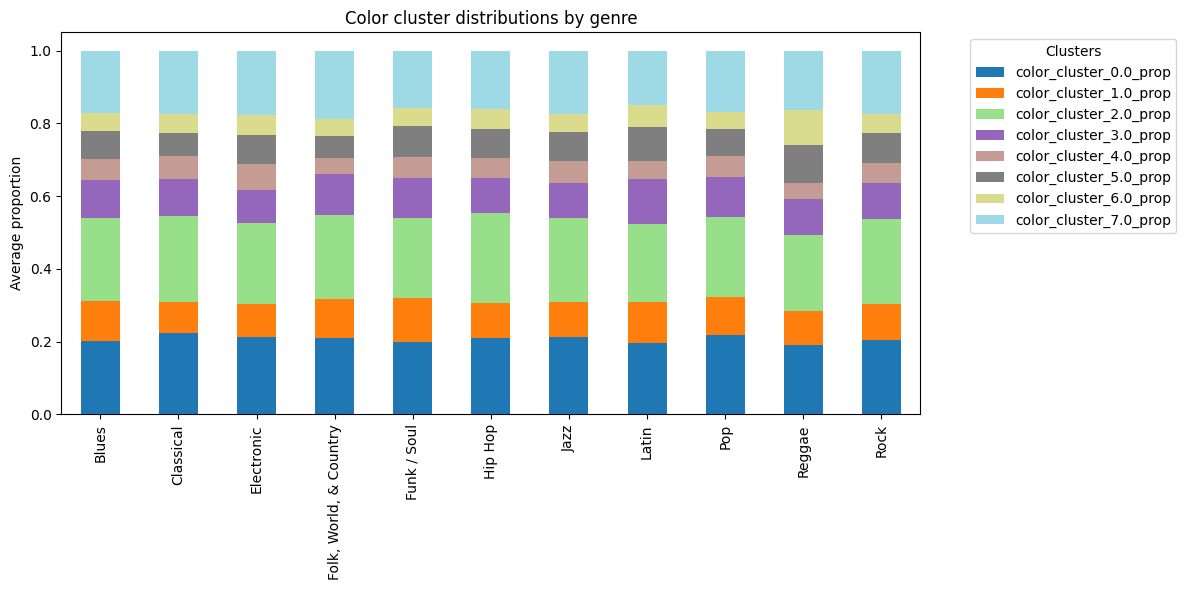

In [70]:
# Average cluster proportions by genre
color_by_genre = {}
for genre in genre_multi_hot_cols:
    mask = df[genre] == 1
    color_by_genre[genre.replace("genre_", "")] = df.loc[mask, [c for c in df.columns if c.startswith("color_cluster_")]].mean()

color_by_genre = pd.DataFrame(color_by_genre).T

# Plot as stacked bar
color_by_genre.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")
plt.ylabel("Average proportion")
plt.title("Color cluster distributions by genre")
plt.legend(bbox_to_anchor=(1.05,1), title="Clusters")
plt.tight_layout()
plt.show()


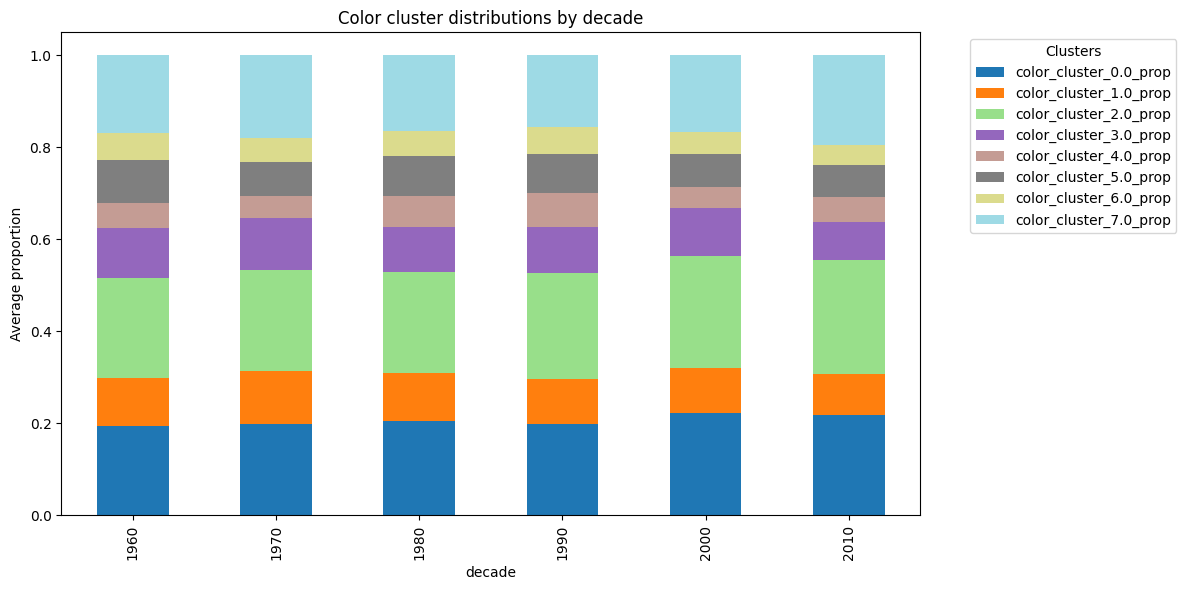

In [71]:
# Create decade column
df["decade"] = (df["year"] // 10 * 10).astype("Int64")

# Average cluster proportions by decade
color_by_decade = (
    df.groupby("decade")[[c for c in df.columns if c.startswith("color_cluster_")]]
      .mean()
)

color_by_decade.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")
plt.ylabel("Average proportion")
plt.title("Color cluster distributions by decade")
plt.legend(bbox_to_anchor=(1.05,1), title="Clusters")
plt.tight_layout()
plt.show()


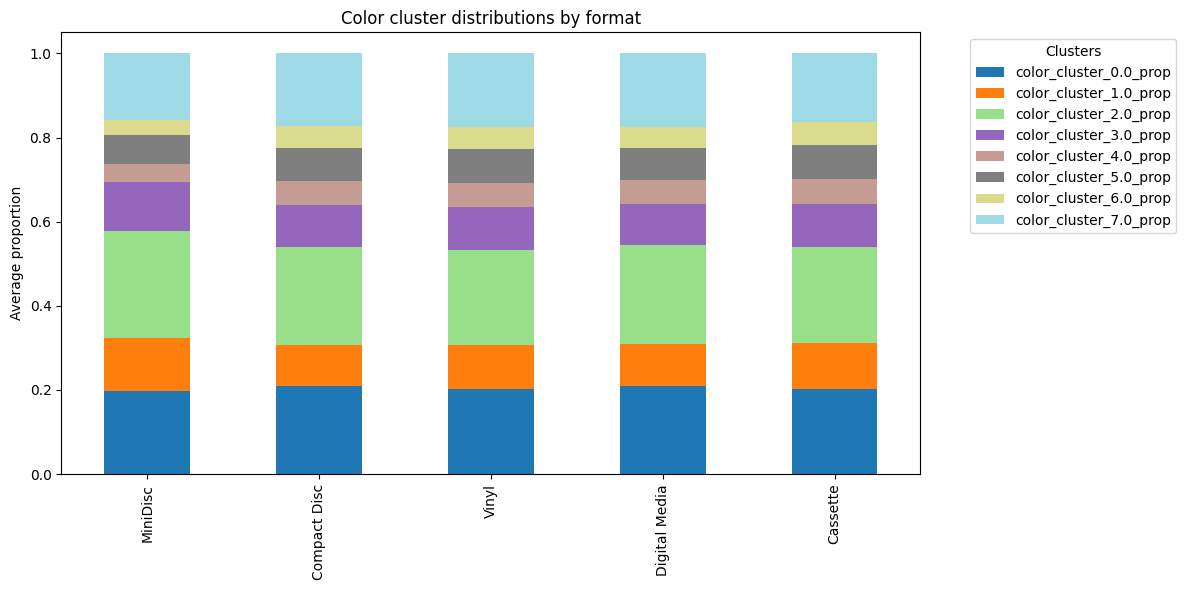

In [72]:
color_by_format = {}
for fmt in format_multi_hot_cols:
    mask = df[fmt] == 1
    color_by_format[fmt.replace("format_", "")] = df.loc[mask, [c for c in df.columns if c.startswith("color_cluster_")]].mean()

color_by_format = pd.DataFrame(color_by_format).T

color_by_format.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")
plt.ylabel("Average proportion")
plt.title("Color cluster distributions by format")
plt.legend(bbox_to_anchor=(1.05,1), title="Clusters")
plt.tight_layout()
plt.show()
